<a href="https://colab.research.google.com/github/MatiasNazareth1993-coder/Virtual-cell/blob/main/Virtual_Cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running a random (untrained) episode...
Untrained total reward: -7.373 steps=8


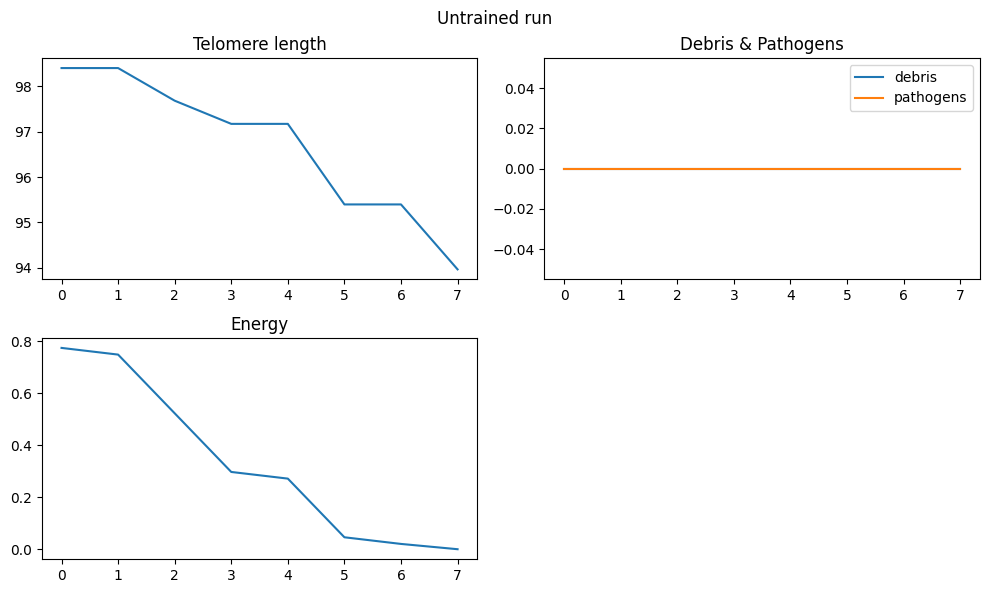


Training controller (this is a lightweight illustrative loop)...
Epoch 000 avg_reward=-7.145
Epoch 010 avg_reward=-8.928
Epoch 020 avg_reward=-16.805
Epoch 030 avg_reward=-34.752
Epoch 040 avg_reward=-45.777
Epoch 050 avg_reward=-39.192
Epoch 060 avg_reward=-83.752
Epoch 070 avg_reward=-64.556

Running a trained episode...
step 0: reward=-0.171 tel=100.25 debris=0.00 pathogens=0.00 energy=0.99
step 1: reward=-0.169 tel=100.89 debris=0.00 pathogens=0.00 energy=0.99
step 2: reward=-0.166 tel=101.44 debris=0.00 pathogens=0.00 energy=0.99
step 3: reward=-0.474 tel=100.78 debris=0.00 pathogens=0.00 energy=0.79
step 4: reward=-0.369 tel=101.51 debris=0.00 pathogens=0.00 energy=0.78
step 5: reward=-0.368 tel=101.93 debris=0.00 pathogens=0.00 energy=0.78
step 6: reward=-0.678 tel=100.92 debris=0.00 pathogens=0.00 energy=0.58
step 7: reward=-0.575 tel=101.43 debris=0.00 pathogens=0.00 energy=0.58
step 8: reward=-0.887 tel=100.28 debris=0.00 pathogens=0.00 energy=0.38
step 9: reward=-0.783 tel=

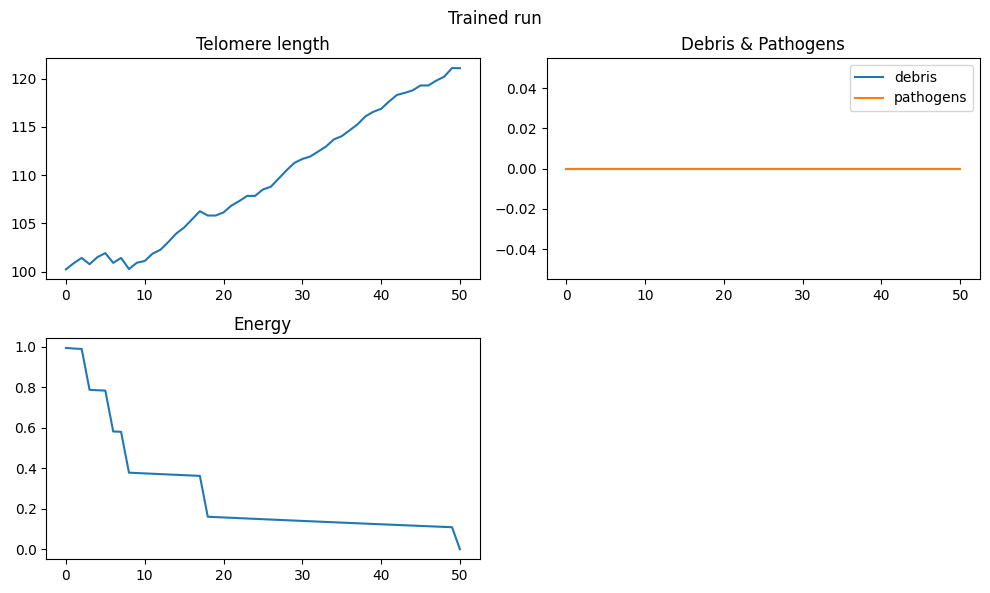

Demo finished. Modify modules in the file to experiment with parameterizations.


In [ ]:
"""
virtual_cell_simulation.py

High-level, safe in-silico simulation of a virtual cell with:
- abstract TelomereModule (maintains "length" numerically)
- PhagocytosisModule (handles debris/pathogen counts)
- DeepController (LSTM-based controller using PyTorch) that outputs
  control actions: telomerase activation probability & phagocytosis effort
- Simulation loop that generates stress events, tracks metrics, and
  trains the controller with a simple policy-gradient-like signal.

SAFETY: This code is purely computational and intentionally avoids any
biologically actionable details (no real DNA sequences, no wet-lab
protocols). It's intended for conceptual in-silico experimentation only.

Requirements (Python packages):
- numpy
- matplotlib
- torch

Run: python virtual_cell_simulation.py

"""

import math
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# ------------------------- Model Components -------------------------

class TelomereModule:
    """
    Abstract numerical telomere model: keeps a scalar "length".
    Actions: apply_telomerase(amount) increases length; replication
    shortens telomeres by a small amount per division. Has noise and
    homeostatic bounds.
    """
    def __init__(self, init_length=100.0, min_length=10.0, max_length=200.0):
        self.length = float(init_length)
        self.min_length = float(min_length)
        self.max_length = float(max_length)

    def replicate(self):
        # replication-associated shortening (abstract)
        delta = random.uniform(0.5, 2.0)
        self.length -= delta
        return delta

    def apply_telomerase(self, strength):
        # strength in [0,1] --> increase proportional to strength
        increase = float(strength) * random.uniform(0.5, 2.5)
        self.length += increase
        # clamp
        self.length = max(self.min_length, min(self.length, self.max_length))
        return increase

    def get_state(self):
        # normalized state for controller
        return np.array([(self.length - self.min_length) / (self.max_length - self.min_length)], dtype=np.float32)


class PhagocytosisModule:
    """
    Abstract phagocytosis: maintains counts of debris and pathogens.
    Actions: effort in [0,1] increases clearance rate but costs energy.
    New debris is generated by damage events.
    """
    def __init__(self, debris=0.0, pathogens=0.0):
        self.debris = float(debris)
        self.pathogens = float(pathogens)

    def step(self, effort):
        # effort reduces debris & pathogens, but imperfectly
        cleared_debris = min(self.debris, effort * random.uniform(0.5, 1.5) * 5.0)
        cleared_pathogens = min(self.pathogens, effort * random.uniform(0.3, 1.2) * 3.0)
        self.debris -= cleared_debris
        self.pathogens -= cleared_pathogens
        return cleared_debris, cleared_pathogens

    def add_damage(self, debris_amt=0.0, pathogen_amt=0.0):
        self.debris += float(debris_amt)
        self.pathogens += float(pathogen_amt)

    def get_state(self):
        # limit and normalize
        total = 1.0 + self.debris + self.pathogens
        return np.array([self.debris / total, self.pathogens / total], dtype=np.float32)


class VirtualCell:
    """
    High-level wrapper that exposes an environment-like API.
    State is concatenation of telomere state + phagocytosis state + simple
    surrogate energetic state.
    """
    def __init__(self, seed=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
        self.tel = TelomereModule()
        self.phago = PhagocytosisModule()
        self.energy = 1.0  # abstract energy level in [0,2]
        self.age = 0
        self.alive = True

    def reset(self):
        self.tel = TelomereModule()
        self.phago = PhagocytosisModule()
        self.energy = 1.0
        self.age = 0
        self.alive = True
        return self.get_state()

    def get_state(self):
        s_tel = self.tel.get_state()  # 1
        s_ph = self.phago.get_state()  # 2
        s_energy = np.array([self.energy / 2.0], dtype=np.float32)
        return np.concatenate([s_tel, s_ph, s_energy]).astype(np.float32)

    def step(self, action):
        # action: [telomerase_prob, telomerase_strength, phago_effort, divide_prob]
        tel_on = float(action[0]) > random.random()
        tel_strength = float(action[1]) if tel_on else 0.0
        phago_effort = float(action[2])
        divide = float(action[3]) > random.random()

        tel_inc = 0.0
        if tel_on:
            tel_inc = self.tel.apply_telomerase(tel_strength)

        # phagocytosis
        cleared_debris, cleared_pathogens = self.phago.step(phago_effort)

        # division
        replication_loss = 0.0
        if divide:
            replication_loss = self.tel.replicate()
            # division costs energy
            self.energy -= 0.2

        # energy dynamics
        # clearing costs energy proportional to effort
        self.energy -= 0.05 * phago_effort
        # pathogens & debris reduce energy over time
        self.energy -= 0.01 * (self.phago.debris + self.phago.pathogens)
        # baseline aging cost
        self.age += 1

        # clamp energy
        self.energy = max(0.0, min(2.0, self.energy))

        # survival condition (abstract): if telomere too short or energy depleted
        if self.tel.length <= self.tel.min_length + 0.1 or self.energy <= 0.01:
            self.alive = False

        # reward shaping: encourage reasonable telomere, low debris/pathogens, moderate energy, and controlled division
        tel_score = -abs((self.tel.length - 120.0) / 120.0)  # ideal target around 120
        phago_score = - (self.phago.debris + self.phago.pathogens) / 10.0
        energy_score = (self.energy - 1.0)
        division_penalty = -0.1 if divide else 0.0

        reward = tel_score + phago_score + energy_score + division_penalty

        # state, reward, done, info
        state = self.get_state()
        done = not self.alive or self.age >= 1000  # cap episode length
        info = {
            'tel_length': self.tel.length,
            'debris': self.phago.debris,
            'pathogens': self.phago.pathogens,
            'energy': self.energy,
            'age': self.age,
            'tel_inc': tel_inc,
            'cleared_debris': cleared_debris,
            'cleared_pathogens': cleared_pathogens,
            'replication_loss': replication_loss,
        }
        return state, reward, done, info

    def stress_event(self, oxidative_damage=0.0, pathogen_inoculum=0.0):
        # adds debris and pathogens; may also cause a small telomere hit (abstract)
        self.phago.add_damage(debris_amt=oxidative_damage, pathogen_amt=pathogen_inoculum)
        # telomere damage (abstract)
        self.tel.length -= random.uniform(0.0, oxidative_damage * 0.5)
        # small energy drain
        self.energy -= 0.05 * oxidative_damage


# ------------------------- Controller (LSTM) -------------------------

class DeepController(nn.Module):
    """
    Small LSTM-based controller that maps environment state -> continuous actions.
    Outputs:
      - tel_prob (sigmoid)
      - tel_strength (sigmoid)
      - phago_effort (sigmoid)
      - divide_prob (sigmoid)

    For clarity and to keep training simple, we use a straightforward
    supervised / policy-gradient-lite training loop in the script below.
    """
    def __init__(self, input_dim=4, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 4)

    def forward(self, x, hx=None):
        # x: (batch, seq, features) but we will call with seq=1
        out, hx = self.lstm(x, hx)
        out = out[:, -1, :]
        out = self.fc(out)
        # map to (0,1)
        out = torch.sigmoid(out)
        return out, hx


# ------------------------- Training / Simulation Loop -------------------------

def run_episode(env, controller, device='cpu', max_steps=1000, render=False):
    controller.eval()
    state = env.reset()
    hx = None
    trajectory = []
    total_reward = 0.0

    for t in range(max_steps):
        s_t = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0).to(device)  # (1,1,feat)
        with torch.no_grad():
            action_tensor, hx = controller(s_t, hx)
        action = action_tensor.squeeze(0).cpu().numpy()  # 4 actions in [0,1]

        # optional stochasticity already considered in env.step (compare probs)
        next_state, reward, done, info = env.step(action)
        trajectory.append((state, action, reward, info))
        total_reward += reward
        state = next_state

        if render:
            print(f"step {t}: reward={reward:.3f} tel={info['tel_length']:.2f} debris={info['debris']:.2f} pathogens={info['pathogens']:.2f} energy={info['energy']:.2f}")

        # occasional stress events
        if t % 50 == 0 and t > 0:
            env.stress_event(oxidative_damage=random.random() * 3.0, pathogen_inoculum=random.random() * 2.0)

        if done:
            break

    return trajectory, total_reward


def train_controller(env, controller, epochs=200, batch_size=4, device='cpu'):
    optimizer = optim.Adam(controller.parameters(), lr=1e-3)
    for epoch in range(epochs):
        controller.train()
        batch_rewards = []
        grads = None
        for b in range(batch_size):
            state = env.reset()
            hx = None
            log_probs = []
            rewards = []
            infos = []
            for t in range(200):
                s_t = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0).to(device)
                action_tensor, hx = controller(s_t, hx)

                # create stochastic actions for training: treat outputs as probabilities
                # and sample Bernoulli for tel_on/divide, and use continuous for strengths/effort
                tel_prob = action_tensor[0,0].item()
                tel_strength = action_tensor[0,1]
                phago_effort = action_tensor[0,2]
                divide_prob = action_tensor[0,3].item()

                tel_on = 1.0 if random.random() < tel_prob else 0.0
                divide_on = 1.0 if random.random() < divide_prob else 0.0
                # assemble action vector
                action = np.array([tel_prob, tel_strength.item(), phago_effort.item(), divide_prob])

                next_state, reward, done, info = env.step(action)
                rewards.append(reward)
                infos.append(info)
                state = next_state
                if done:
                    break

            batch_rewards.append(sum(rewards))

            # simple policy gradient surrogate: maximize cumulative reward by
            # doing a baseline subtraction. Here we use cumulative reward as signal
            R = sum(rewards)
            # compute loss: negative reward times log-probability surrogate
            # but since controller outputs continuous values mapped by sigmoid,
            # and we sampled probs above only for tel & divide, we form a toy loss
            # that nudges outputs toward behaviors that gave higher R.
            # This is a very lightweight, not production RL algorithm.
            optimizer.zero_grad()
            # create one-step training target using the final state as target heuristic
            final_state = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0).to(device)
            pred_actions, _ = controller(final_state)
            # Construct a target action vector heuristically from infos[-1]
            last_info = infos[-1] if len(infos) > 0 else env.get_state()
            # target: keep telomere near 120 -> if below, encourage telomerase; if above, discourage
            tel_len = last_info['tel_length'] if isinstance(last_info, dict) else 100.0
            tel_target = 1.0 if tel_len < 120.0 else 0.0
            phago_target = 1.0 if (last_info['debris'] + last_info['pathogens']) > 1.0 else 0.0
            divide_target = 0.1  # discourage frequent dividing
            target = torch.tensor([[tel_target, 0.6 * tel_target, phago_target, divide_target]], dtype=torch.float32).to(device)

            loss = nn.functional.mse_loss(pred_actions, target) * (1.0 / (1.0 + math.exp(-R/10.0)))
            loss.backward()
            optimizer.step()

        avg_batch_reward = sum(batch_rewards) / len(batch_rewards)
        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d} avg_reward={avg_batch_reward:.3f}")

    return controller


# ------------------------- Utilities / Visualization -------------------------

def plot_trajectory(trajectory, title="Trajectory metrics"):
    tel_lengths = [info['tel_length'] for _,_,_,info in trajectory]
    debris = [info['debris'] for _,_,_,info in trajectory]
    pathogens = [info['pathogens'] for _,_,_,info in trajectory]
    energy = [info['energy'] for _,_,_,info in trajectory]

    steps = list(range(len(tel_lengths)))
    plt.figure(figsize=(10,6))
    plt.subplot(2,2,1)
    plt.plot(steps, tel_lengths)
    plt.title('Telomere length')

    plt.subplot(2,2,2)
    plt.plot(steps, debris, label='debris')
    plt.plot(steps, pathogens, label='pathogens')
    plt.legend()
    plt.title('Debris & Pathogens')

    plt.subplot(2,2,3)
    plt.plot(steps, energy)
    plt.title('Energy')

    plt.tight_layout()
    plt.suptitle(title)
    plt.subplots_adjust(top=0.9)
    plt.show()


# ------------------------- Main runnable demo -------------------------

if __name__ == '__main__':
    device = 'cpu'
    env = VirtualCell(seed=42)
    controller = DeepController(input_dim=4, hidden_dim=64).to(device)

    print("Running a random (untrained) episode...")
    traj, rew = run_episode(env, controller, device=device, max_steps=300, render=False)
    print(f"Untrained total reward: {rew:.3f} steps={len(traj)}")
    plot_trajectory(traj, title='Untrained run')

    print("\nTraining controller (this is a lightweight illustrative loop)...")
    controller = train_controller(env, controller, epochs=80, batch_size=6, device=device)

    print("\nRunning a trained episode...")
    traj2, rew2 = run_episode(env, controller, device=device, max_steps=500, render=True)
    print(f"Trained total reward: {rew2:.3f} steps={len(traj2)}")
    plot_trajectory(traj2, title='Trained run')

    print("Demo finished. Modify modules in the file to experiment with parameterizations.")

Running a random (untrained) episode...
Untrained total reward: 12.918 steps=8


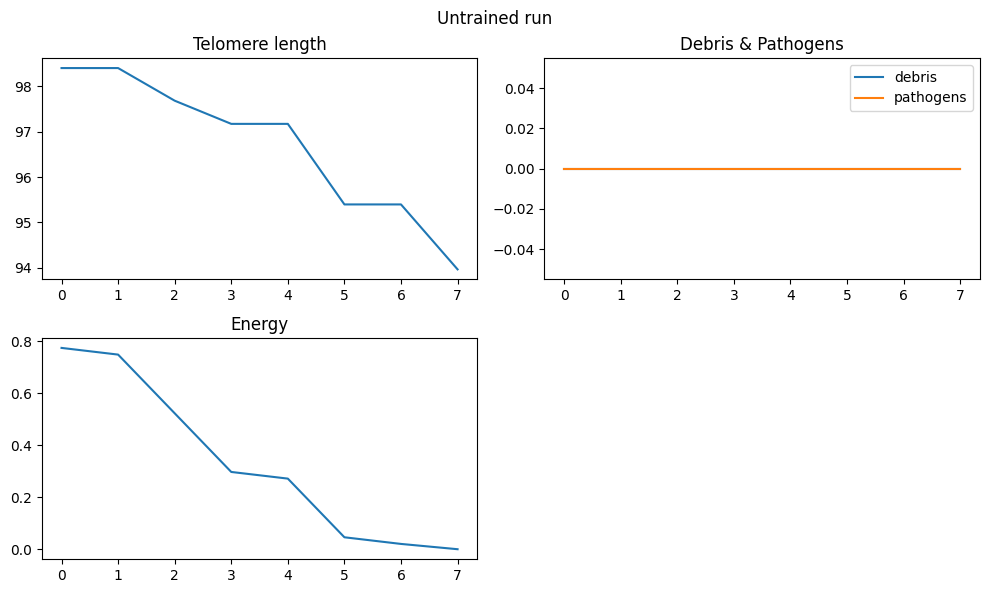


Training controller (this is a lightweight illustrative loop)...
Epoch 000 avg_reward=16.447
Epoch 010 avg_reward=20.549
Epoch 020 avg_reward=91.234
Epoch 030 avg_reward=137.872
Epoch 040 avg_reward=274.149
Epoch 050 avg_reward=288.700
Epoch 060 avg_reward=392.417
Epoch 070 avg_reward=317.432

Running a trained episode...
step 0: reward=2.139 tel=100.63 debris=0.00 pathogens=0.00 energy=1.00
step 1: reward=2.139 tel=100.63 debris=0.00 pathogens=0.00 energy=1.00
step 2: reward=2.143 tel=100.99 debris=0.00 pathogens=0.00 energy=1.00
step 3: reward=2.146 tel=101.34 debris=0.00 pathogens=0.00 energy=1.00
step 4: reward=2.148 tel=101.54 debris=0.00 pathogens=0.00 energy=1.00
step 5: reward=2.148 tel=101.54 debris=0.00 pathogens=0.00 energy=1.00
step 6: reward=2.152 tel=101.91 debris=0.00 pathogens=0.00 energy=1.00
step 7: reward=2.155 tel=102.26 debris=0.00 pathogens=0.00 energy=1.00
step 8: reward=2.155 tel=102.26 debris=0.00 pathogens=0.00 energy=1.00
step 9: reward=2.158 tel=102.50 debr

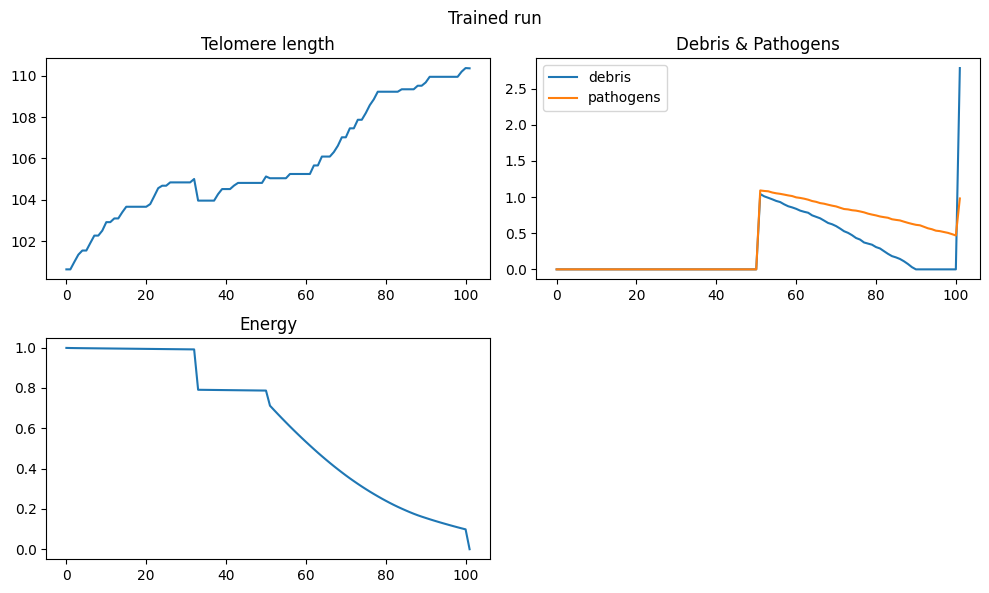

Demo finished. Modify modules in the file to experiment with parameterizations.


In [ ]:
"""
virtual_cell_simulation.py

High-level, safe in-silico simulation of a virtual cell with:
- abstract TelomereModule (maintains "length" numerically)
- PhagocytosisModule (handles debris/pathogen counts)
- DeepController (LSTM-based controller using PyTorch) that outputs
  control actions: telomerase activation probability & phagocytosis effort
- Simulation loop that generates stress events, tracks metrics, and
  trains the controller with a simple policy-gradient-like signal.

SAFETY: This code is purely computational and intentionally avoids any
biologically actionable details (no real DNA sequences, no wet-lab
protocols). It's intended for conceptual in-silico experimentation only.

Requirements (Python packages):
- numpy
- matplotlib
- torch

Run: python virtual_cell_simulation.py

"""

import math
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# ------------------------- Model Components -------------------------

from dataclasses import dataclass

@dataclass
class RewardConfig:
    """Configurable reward weights and parameters for tuning behavior.
    Tweak these numbers to emphasize telomere maintenance vs cleanup vs energy
    or to add survival/penalties for division.
    """
    tel_target: float = 120.0
    tel_window: float = 40.0  # defines how "wide" the reward peak is
    tel_weight: float = 1.0
    phago_weight: float = 1.0
    energy_weight: float = 0.5
    division_penalty: float = 0.5  # penalty when a division occurs
    survival_bonus: float = 0.0  # bonus for staying alive each step
    debris_scale: float = 10.0  # normalizer for debris+pathogens

    def telomere_reward(self, length: float) -> float:
        # Use a smooth, peaked reward around tel_target (Gaussian-like)
        diff = (length - self.tel_target) / self.tel_window
        return math.exp(-0.5 * (diff ** 2))  # in (0,1]

    def phagocytosis_reward(self, debris: float, pathogens: float) -> float:
        # High debris/pathogen reduces reward (we return positive value)
        return 1.0 - ((debris + pathogens) / self.debris_scale)

    def energy_reward(self, energy: float) -> float:
        # Encourage moderate-to-high energy (energy in [0,2])
        return (energy / 2.0)


class TelomereModule:
    """
    Abstract numerical telomere model: keeps a scalar "length".
    Actions: apply_telomerase(amount) increases length; replication
    shortens telomeres by a small amount per division. Has noise and
    homeostatic bounds.
    """
    def __init__(self, init_length=100.0, min_length=10.0, max_length=200.0):
        self.length = float(init_length)
        self.min_length = float(min_length)
        self.max_length = float(max_length)

    def replicate(self):
        # replication-associated shortening (abstract)
        delta = random.uniform(0.5, 2.0)
        self.length -= delta
        return delta

    def apply_telomerase(self, strength):
        # strength in [0,1] --> increase proportional to strength
        increase = float(strength) * random.uniform(0.5, 2.5)
        self.length += increase
        # clamp
        self.length = max(self.min_length, min(self.length, self.max_length))
        return increase

    def get_state(self):
        # normalized state for controller
        return np.array([(self.length - self.min_length) / (self.max_length - self.min_length)], dtype=np.float32)


class PhagocytosisModule:
    """
    Abstract phagocytosis: maintains counts of debris and pathogens.
    Actions: effort in [0,1] increases clearance rate but costs energy.
    New debris is generated by damage events.
    """
    def __init__(self, debris=0.0, pathogens=0.0):
        self.debris = float(debris)
        self.pathogens = float(pathogens)

    def step(self, effort):
        # effort reduces debris & pathogens, but imperfectly
        cleared_debris = min(self.debris, effort * random.uniform(0.5, 1.5) * 5.0)
        cleared_pathogens = min(self.pathogens, effort * random.uniform(0.3, 1.2) * 3.0)
        self.debris -= cleared_debris
        self.pathogens -= cleared_pathogens
        return cleared_debris, cleared_pathogens

    def add_damage(self, debris_amt=0.0, pathogen_amt=0.0):
        self.debris += float(debris_amt)
        self.pathogens += float(pathogen_amt)

    def get_state(self):
        # limit and normalize
        total = 1.0 + self.debris + self.pathogens
        return np.array([self.debris / total, self.pathogens / total], dtype=np.float32)


class VirtualCell:
    """
    High-level wrapper that exposes an environment-like API.
    State is concatenation of telomere state + phagocytosis state + simple
    surrogate energetic state.
    """
    def __init__(self, seed=None, reward_config=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
        self.tel = TelomereModule()
        self.phago = PhagocytosisModule()
        self.energy = 1.0  # abstract energy level in [0,2]
        self.age = 0
        self.alive = True
        # reward configuration (tunable)
        self.reward_config = reward_config if reward_config is not None else RewardConfig()

    def reset(self):
        self.tel = TelomereModule()
        self.phago = PhagocytosisModule()
        self.energy = 1.0
        self.age = 0
        self.alive = True
        return self.get_state()

    def get_state(self):
        s_tel = self.tel.get_state()  # 1
        s_ph = self.phago.get_state()  # 2
        s_energy = np.array([self.energy / 2.0], dtype=np.float32)
        return np.concatenate([s_tel, s_ph, s_energy]).astype(np.float32)

    def step(self, action):
        # action: [telomerase_prob, telomerase_strength, phago_effort, divide_prob]
        tel_on = float(action[0]) > random.random()
        tel_strength = float(action[1]) if tel_on else 0.0
        phago_effort = float(action[2])
        divide = float(action[3]) > random.random()

        tel_inc = 0.0
        if tel_on:
            tel_inc = self.tel.apply_telomerase(tel_strength)

        # phagocytosis
        cleared_debris, cleared_pathogens = self.phago.step(phago_effort)

        # division
        replication_loss = 0.0
        if divide:
            replication_loss = self.tel.replicate()
            # division costs energy
            self.energy -= 0.2

        # energy dynamics
        # clearing costs energy proportional to effort
        self.energy -= 0.05 * phago_effort
        # pathogens & debris reduce energy over time
        self.energy -= 0.01 * (self.phago.debris + self.phago.pathogens)
        # baseline aging cost
        self.age += 1

        # clamp energy
        self.energy = max(0.0, min(2.0, self.energy))

        # survival condition (abstract): if telomere too short or energy depleted
        if self.tel.length <= self.tel.min_length + 0.1 or self.energy <= 0.01:
            self.alive = False

        # reward shaping: configurable and tunable via RewardConfig
        tel_reward = self.reward_config.telomere_reward(self.tel.length)  # (0,1]
        phago_reward = max(0.0, self.reward_config.phagocytosis_reward(self.phago.debris, self.phago.pathogens))
        energy_reward = self.reward_config.energy_reward(self.energy)
        division_penalty = -self.reward_config.division_penalty if divide else 0.0

        # weighted sum (we keep it bounded and numerically stable)
        reward = (
            self.reward_config.tel_weight * tel_reward
            + self.reward_config.phago_weight * phago_reward
            + self.reward_config.energy_weight * energy_reward
            + division_penalty
            + self.reward_config.survival_bonus
        )

        # small shaping to discourage extremely long telomeres (optional)
        if self.tel.length > self.tel.max_length * 0.95:
            reward -= 0.2

        # state, reward, done, info
        state = self.get_state()
        done = not self.alive or self.age >= 1000  # cap episode length
        info = {
            'tel_length': self.tel.length,
            'debris': self.phago.debris,
            'pathogens': self.phago.pathogens,
            'energy': self.energy,
            'age': self.age,
            'tel_inc': tel_inc,
            'cleared_debris': cleared_debris,
            'cleared_pathogens': cleared_pathogens,
            'replication_loss': replication_loss,
        }
        return state, reward, done, info

    def stress_event(self, oxidative_damage=0.0, pathogen_inoculum=0.0):
        # adds debris and pathogens; may also cause a small telomere hit (abstract)
        self.phago.add_damage(debris_amt=oxidative_damage, pathogen_amt=pathogen_inoculum)
        # telomere damage (abstract)
        self.tel.length -= random.uniform(0.0, oxidative_damage * 0.5)
        # small energy drain
        self.energy -= 0.05 * oxidative_damage


# ------------------------- Controller (LSTM) -------------------------

class DeepController(nn.Module):
    """
    Small LSTM-based controller that maps environment state -> continuous actions.
    Outputs:
      - tel_prob (sigmoid)
      - tel_strength (sigmoid)
      - phago_effort (sigmoid)
      - divide_prob (sigmoid)

    For clarity and to keep training simple, we use a straightforward
    supervised / policy-gradient-lite training loop in the script below.
    """
    def __init__(self, input_dim=4, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 4)

    def forward(self, x, hx=None):
        # x: (batch, seq, features) but we will call with seq=1
        out, hx = self.lstm(x, hx)
        out = out[:, -1, :]
        out = self.fc(out)
        # map to (0,1)
        out = torch.sigmoid(out)
        return out, hx


# ------------------------- Training / Simulation Loop -------------------------

def run_episode(env, controller, device='cpu', max_steps=1000, render=False):
    controller.eval()
    state = env.reset()
    hx = None
    trajectory = []
    total_reward = 0.0

    for t in range(max_steps):
        s_t = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0).to(device)  # (1,1,feat)
        with torch.no_grad():
            action_tensor, hx = controller(s_t, hx)
        action = action_tensor.squeeze(0).cpu().numpy()  # 4 actions in [0,1]

        # optional stochasticity already considered in env.step (compare probs)
        next_state, reward, done, info = env.step(action)
        trajectory.append((state, action, reward, info))
        total_reward += reward
        state = next_state

        if render:
            print(f"step {t}: reward={reward:.3f} tel={info['tel_length']:.2f} debris={info['debris']:.2f} pathogens={info['pathogens']:.2f} energy={info['energy']:.2f}")

        # occasional stress events
        if t % 50 == 0 and t > 0:
            env.stress_event(oxidative_damage=random.random() * 3.0, pathogen_inoculum=random.random() * 2.0)

        if done:
            break

    return trajectory, total_reward


def train_controller(env, controller, epochs=200, batch_size=4, device='cpu'):
    optimizer = optim.Adam(controller.parameters(), lr=1e-3)
    for epoch in range(epochs):
        controller.train()
        batch_rewards = []
        grads = None
        for b in range(batch_size):
            state = env.reset()
            hx = None
            log_probs = []
            rewards = []
            infos = []
            for t in range(200):
                s_t = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0).to(device)
                action_tensor, hx = controller(s_t, hx)

                # create stochastic actions for training: treat outputs as probabilities
                # and sample Bernoulli for tel_on/divide, and use continuous for strengths/effort
                tel_prob = action_tensor[0,0].item()
                tel_strength = action_tensor[0,1]
                phago_effort = action_tensor[0,2]
                divide_prob = action_tensor[0,3].item()

                tel_on = 1.0 if random.random() < tel_prob else 0.0
                divide_on = 1.0 if random.random() < divide_prob else 0.0
                # assemble action vector
                action = np.array([tel_prob, tel_strength.item(), phago_effort.item(), divide_prob])

                next_state, reward, done, info = env.step(action)
                rewards.append(reward)
                infos.append(info)
                state = next_state
                if done:
                    break

            batch_rewards.append(sum(rewards))

            # simple policy gradient surrogate: maximize cumulative reward by
            # doing a baseline subtraction. Here we use cumulative reward as signal
            R = sum(rewards)
            # compute loss: negative reward times log-probability surrogate
            # but since controller outputs continuous values mapped by sigmoid,
            # and we sampled probs above only for tel & divide, we form a toy loss
            # that nudges outputs toward behaviors that gave higher R.
            # This is a very lightweight, not production RL algorithm.
            optimizer.zero_grad()
            # create one-step training target using the final state as target heuristic
            final_state = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0).to(device)
            pred_actions, _ = controller(final_state)
            # Construct a target action vector heuristically from infos[-1]
            last_info = infos[-1] if len(infos) > 0 else env.get_state()
            # target: keep telomere near 120 -> if below, encourage telomerase; if above, discourage
            tel_len = last_info['tel_length'] if isinstance(last_info, dict) else 100.0
            tel_target = 1.0 if tel_len < 120.0 else 0.0
            phago_target = 1.0 if (last_info['debris'] + last_info['pathogens']) > 1.0 else 0.0
            divide_target = 0.1  # discourage frequent dividing
            target = torch.tensor([[tel_target, 0.6 * tel_target, phago_target, divide_target]], dtype=torch.float32).to(device)

            loss = nn.functional.mse_loss(pred_actions, target) * (1.0 / (1.0 + math.exp(-R/10.0)))
            loss.backward()
            optimizer.step()

        avg_batch_reward = sum(batch_rewards) / len(batch_rewards)
        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d} avg_reward={avg_batch_reward:.3f}")

    return controller


# ------------------------- Utilities / Visualization -------------------------

def plot_trajectory(trajectory, title="Trajectory metrics"):
    tel_lengths = [info['tel_length'] for _,_,_,info in trajectory]
    debris = [info['debris'] for _,_,_,info in trajectory]
    pathogens = [info['pathogens'] for _,_,_,info in trajectory]
    energy = [info['energy'] for _,_,_,info in trajectory]

    steps = list(range(len(tel_lengths)))
    plt.figure(figsize=(10,6))
    plt.subplot(2,2,1)
    plt.plot(steps, tel_lengths)
    plt.title('Telomere length')

    plt.subplot(2,2,2)
    plt.plot(steps, debris, label='debris')
    plt.plot(steps, pathogens, label='pathogens')
    plt.legend()
    plt.title('Debris & Pathogens')

    plt.subplot(2,2,3)
    plt.plot(steps, energy)
    plt.title('Energy')

    plt.tight_layout()
    plt.suptitle(title)
    plt.subplots_adjust(top=0.9)
    plt.show()


# ------------------------- Main runnable demo -------------------------

if __name__ == '__main__':
    device = 'cpu'
    env = VirtualCell(seed=42)
    controller = DeepController(input_dim=4, hidden_dim=64).to(device)

    print("Running a random (untrained) episode...")
    traj, rew = run_episode(env, controller, device=device, max_steps=300, render=False)
    print(f"Untrained total reward: {rew:.3f} steps={len(traj)}")
    plot_trajectory(traj, title='Untrained run')

    print("\nTraining controller (this is a lightweight illustrative loop)...")
    controller = train_controller(env, controller, epochs=80, batch_size=6, device=device)

    print("\nRunning a trained episode...")
    traj2, rew2 = run_episode(env, controller, device=device, max_steps=500, render=True)
    print(f"Trained total reward: {rew2:.3f} steps={len(traj2)}")
    plot_trajectory(traj2, title='Trained run')

    print("Demo finished. Modify modules in the file to experiment with parameterizations.")

Total reward: 12.918, steps=8


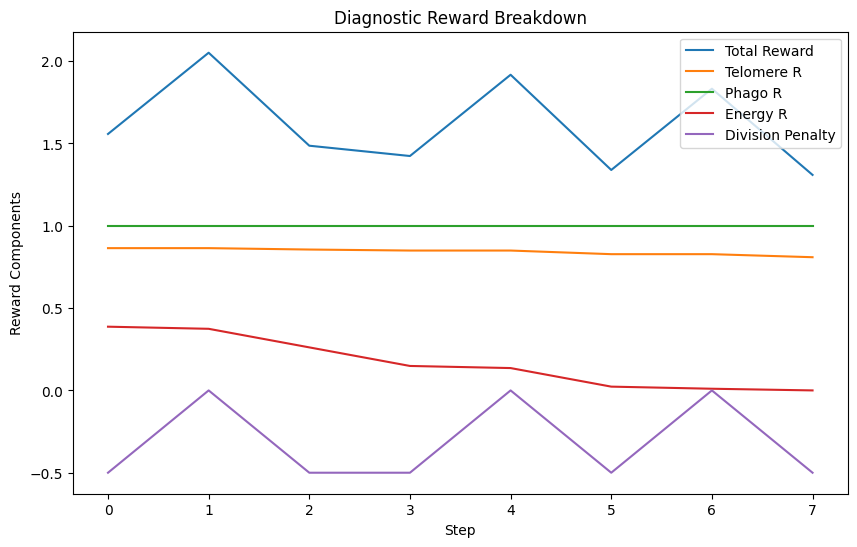

In [ ]:
"""
virtual_cell_simulation.py

High-level, safe in-silico simulation of a virtual cell with diagnostic tracing.
This version includes configurable reward tuning and detailed diagnostics to
observe how each reward component contributes to overall learning stability.

Purely computational, no biological data. Intended for conceptual exploration.
"""

import math
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from dataclasses import dataclass

# ------------------------- Reward Configuration -------------------------

@dataclass
class RewardConfig:
    tel_target: float = 120.0
    tel_window: float = 40.0
    tel_weight: float = 1.0
    phago_weight: float = 1.0
    energy_weight: float = 0.5
    division_penalty: float = 0.5
    survival_bonus: float = 0.0
    debris_scale: float = 10.0

    def telomere_reward(self, length: float) -> float:
        diff = (length - self.tel_target) / self.tel_window
        return math.exp(-0.5 * (diff ** 2))

    def phagocytosis_reward(self, debris: float, pathogens: float) -> float:
        return 1.0 - ((debris + pathogens) / self.debris_scale)

    def energy_reward(self, energy: float) -> float:
        return (energy / 2.0)


# ------------------------- Core Cell Modules -------------------------

class TelomereModule:
    def __init__(self, init_length=100.0, min_length=10.0, max_length=200.0):
        self.length = float(init_length)
        self.min_length = float(min_length)
        self.max_length = float(max_length)

    def replicate(self):
        delta = random.uniform(0.5, 2.0)
        self.length -= delta
        return delta

    def apply_telomerase(self, strength):
        increase = float(strength) * random.uniform(0.5, 2.5)
        self.length += increase
        self.length = max(self.min_length, min(self.length, self.max_length))
        return increase

    def get_state(self):
        return np.array([(self.length - self.min_length) / (self.max_length - self.min_length)], dtype=np.float32)


class PhagocytosisModule:
    def __init__(self, debris=0.0, pathogens=0.0):
        self.debris = float(debris)
        self.pathogens = float(pathogens)

    def step(self, effort):
        cleared_debris = min(self.debris, effort * random.uniform(0.5, 1.5) * 5.0)
        cleared_pathogens = min(self.pathogens, effort * random.uniform(0.3, 1.2) * 3.0)
        self.debris -= cleared_debris
        self.pathogens -= cleared_pathogens
        return cleared_debris, cleared_pathogens

    def add_damage(self, debris_amt=0.0, pathogen_amt=0.0):
        self.debris += float(debris_amt)
        self.pathogens += float(pathogen_amt)

    def get_state(self):
        total = 1.0 + self.debris + self.pathogens
        return np.array([self.debris / total, self.pathogens / total], dtype=np.float32)


# ------------------------- Virtual Cell -------------------------

class VirtualCell:
    def __init__(self, seed=None, reward_config=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
        self.tel = TelomereModule()
        self.phago = PhagocytosisModule()
        self.energy = 1.0
        self.age = 0
        self.alive = True
        self.reward_config = reward_config if reward_config is not None else RewardConfig()

    def reset(self):
        self.tel = TelomereModule()
        self.phago = PhagocytosisModule()
        self.energy = 1.0
        self.age = 0
        self.alive = True
        return self.get_state()

    def get_state(self):
        s_tel = self.tel.get_state()
        s_ph = self.phago.get_state()
        s_energy = np.array([self.energy / 2.0], dtype=np.float32)
        return np.concatenate([s_tel, s_ph, s_energy]).astype(np.float32)

    def step(self, action):
        tel_on = float(action[0]) > random.random()
        tel_strength = float(action[1]) if tel_on else 0.0
        phago_effort = float(action[2])
        divide = float(action[3]) > random.random()

        tel_inc = self.tel.apply_telomerase(tel_strength) if tel_on else 0.0
        cleared_debris, cleared_pathogens = self.phago.step(phago_effort)
        replication_loss = self.tel.replicate() if divide else 0.0
        self.energy -= 0.05 * phago_effort + 0.01 * (self.phago.debris + self.phago.pathogens)
        if divide:
            self.energy -= 0.2
        self.energy = max(0.0, min(2.0, self.energy))
        self.age += 1
        if self.tel.length <= self.tel.min_length + 0.1 or self.energy <= 0.01:
            self.alive = False

        # diagnostic components
        tel_r = self.reward_config.telomere_reward(self.tel.length)
        phago_r = max(0.0, self.reward_config.phagocytosis_reward(self.phago.debris, self.phago.pathogens))
        energy_r = self.reward_config.energy_reward(self.energy)
        division_penalty = -self.reward_config.division_penalty if divide else 0.0
        survival_r = self.reward_config.survival_bonus

        reward = (
            self.reward_config.tel_weight * tel_r
            + self.reward_config.phago_weight * phago_r
            + self.reward_config.energy_weight * energy_r
            + division_penalty
            + survival_r
        )
        if self.tel.length > self.tel.max_length * 0.95:
            reward -= 0.2

        state = self.get_state()
        done = not self.alive or self.age >= 1000
        info = {
            'tel_length': self.tel.length,
            'debris': self.phago.debris,
            'pathogens': self.phago.pathogens,
            'energy': self.energy,
            'age': self.age,
            'tel_r': tel_r,
            'phago_r': phago_r,
            'energy_r': energy_r,
            'division_penalty': division_penalty,
            'reward_total': reward,
        }
        return state, reward, done, info

    def stress_event(self, oxidative_damage=0.0, pathogen_inoculum=0.0):
        self.phago.add_damage(debris_amt=oxidative_damage, pathogen_amt=pathogen_inoculum)
        self.tel.length -= random.uniform(0.0, oxidative_damage * 0.5)
        self.energy -= 0.05 * oxidative_damage


# ------------------------- Controller -------------------------

class DeepController(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 4)

    def forward(self, x, hx=None):
        out, hx = self.lstm(x, hx)
        out = out[:, -1, :]
        out = self.fc(out)
        return torch.sigmoid(out), hx


# ------------------------- Simulation & Diagnostics -------------------------

def run_episode(env, controller, device='cpu', max_steps=500):
    controller.eval()
    state = env.reset()
    hx = None
    trajectory, diagnostics = [], []
    total_reward = 0.0

    for t in range(max_steps):
        s_t = torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            action_tensor, hx = controller(s_t, hx)
        action = action_tensor.squeeze(0).cpu().numpy()

        next_state, reward, done, info = env.step(action)
        trajectory.append(info)
        total_reward += reward
        state = next_state
        diagnostics.append({
            'step': t,
            'reward_total': info['reward_total'],
            'tel_r': info['tel_r'],
            'phago_r': info['phago_r'],
            'energy_r': info['energy_r'],
            'division_penalty': info['division_penalty']
        })

        if t % 50 == 0 and t > 0:
            env.stress_event(oxidative_damage=random.random() * 3.0, pathogen_inoculum=random.random() * 2.0)
        if done:
            break
    return trajectory, diagnostics, total_reward


def plot_diagnostics(diagnostics):
    steps = [d['step'] for d in diagnostics]
    plt.figure(figsize=(10,6))
    plt.plot(steps, [d['reward_total'] for d in diagnostics], label='Total Reward')
    plt.plot(steps, [d['tel_r'] for d in diagnostics], label='Telomere R')
    plt.plot(steps, [d['phago_r'] for d in diagnostics], label='Phago R')
    plt.plot(steps, [d['energy_r'] for d in diagnostics], label='Energy R')
    plt.plot(steps, [d['division_penalty'] for d in diagnostics], label='Division Penalty')
    plt.xlabel('Step')
    plt.ylabel('Reward Components')
    plt.legend()
    plt.title('Diagnostic Reward Breakdown')
    plt.show()


if __name__ == '__main__':
    device = 'cpu'
    env = VirtualCell(seed=42)
    controller = DeepController(input_dim=4)
    traj, diag, total = run_episode(env, controller, device)
    print(f"Total reward: {total:.3f}, steps={len(traj)}")
    plot_diagnostics(diag)

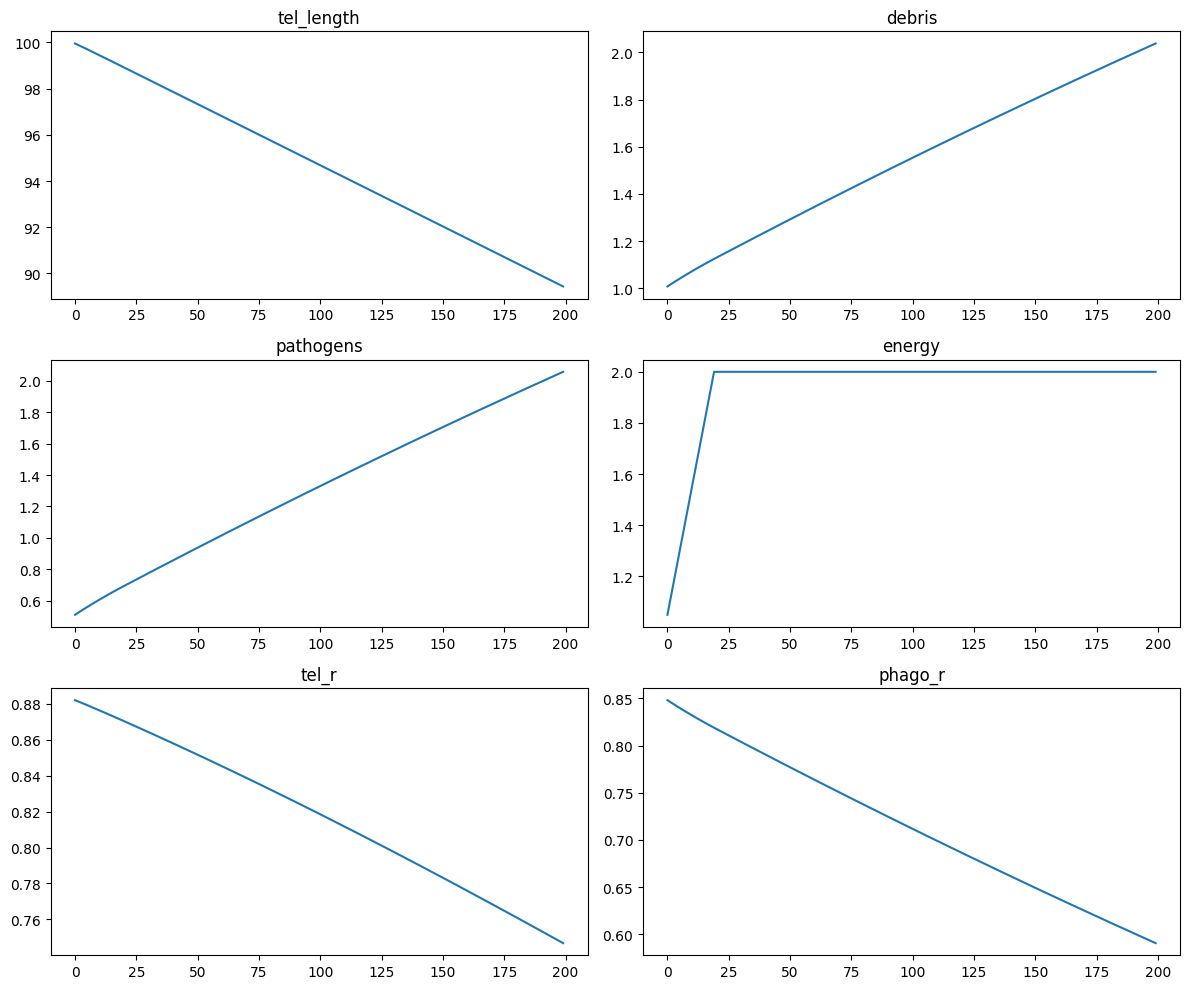


Reward Correlations with total reward:
 reward_total        1.000000
tel_r               0.937249
tel_length          0.930646
phago_r             0.923344
energy             -0.096326
energy_r           -0.096326
pathogens          -0.923344
debris             -0.923344
division_penalty         NaN
Name: reward_total, dtype: float64


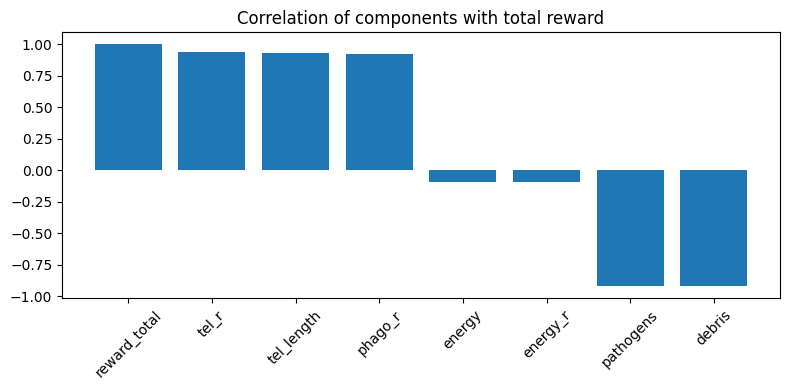

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
from dataclasses import dataclass

# ------------------------- Reward Configuration -------------------------
@dataclass
class RewardConfig:
    tel_target: float = 120.0
    tel_window: float = 40.0
    tel_weight: float = 1.0
    phago_weight: float = 1.0
    energy_weight: float = 0.5
    division_penalty: float = 0.5
    survival_bonus: float = 0.0
    debris_scale: float = 10.0

    def telomere_reward(self, length: float) -> float:
        diff = (length - self.tel_target) / self.tel_window
        return math.exp(-0.5 * (diff ** 2))

    def phagocytosis_reward(self, debris: float, pathogens: float) -> float:
        return 1.0 - ((debris + pathogens) / self.debris_scale)

    def energy_reward(self, energy: float) -> float:
        return (energy / 2.0)

# ------------------------- Model Components -------------------------
class TelomereModule:
    def __init__(self):
        self.length = 100.0
        self.max_length = 200.0

    def update(self, telomerase_activity):
        self.length += 0.1 * telomerase_activity - 0.05
        self.length = np.clip(self.length, 0, self.max_length)

class PhagocytosisModule:
    def __init__(self):
        self.debris = 1.0
        self.pathogens = 0.5

    def update(self, activity):
        self.debris = max(0.0, self.debris - 0.1 * activity)
        self.pathogens = max(0.0, self.pathogens - 0.15 * activity)

# ------------------------- Deep Learning Controller -------------------------
class DeepController(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=32, output_dim=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hc=None):
        out, hc = self.lstm(x, hc)
        out = self.fc(out[:, -1, :])
        return torch.tanh(out), hc

# ------------------------- Virtual Cell -------------------------
class VirtualCell:
    def __init__(self, seed=None, reward_config=None):
        self.tel = TelomereModule()
        self.phago = PhagocytosisModule()
        self.energy = 1.0
        self.divisions = 0
        self.alive = True
        self.reward_config = reward_config if reward_config is not None else RewardConfig()
        self.trace = []

    def step(self, telomerase_activity, phago_activity, divide):
        self.tel.update(telomerase_activity)
        self.phago.update(phago_activity)
        if divide:
            self.divisions += 1
            self.energy -= 0.2
        else:
            self.energy = min(2.0, self.energy + 0.05)

        tel_r = self.reward_config.telomere_reward(self.tel.length)
        phago_r = max(0.0, self.reward_config.phagocytosis_reward(self.phago.debris, self.phago.pathogens))
        energy_r = self.reward_config.energy_reward(self.energy)
        division_penalty = -self.reward_config.division_penalty if divide else 0.0

        reward = (
            self.reward_config.tel_weight * tel_r
            + self.reward_config.phago_weight * phago_r
            + self.reward_config.energy_weight * energy_r
            + division_penalty
            + self.reward_config.survival_bonus
        )

        if self.tel.length > self.tel.max_length * 0.95:
            reward -= 0.2

        self.trace.append({
            'tel_length': self.tel.length,
            'debris': self.phago.debris,
            'pathogens': self.phago.pathogens,
            'energy': self.energy,
            'tel_r': tel_r,
            'phago_r': phago_r,
            'energy_r': energy_r,
            'division_penalty': division_penalty,
            'reward_total': reward
        })
        return reward

# ------------------------- Simulation Loop -------------------------
def run_simulation(steps=100):
    cell = VirtualCell()
    controller = DeepController()
    hc = None
    for t in range(steps):
        state = torch.tensor([[cell.tel.length / 200.0, cell.phago.debris / 10.0, cell.phago.pathogens / 10.0, cell.energy / 2.0]], dtype=torch.float32).unsqueeze(0)
        action, hc = controller(state, hc)
        tel_act, phago_act, divide_act = action[0]
        divide = divide_act.item() > 0.5
        cell.step(float(tel_act.item()), float(phago_act.item()), divide)
    return cell

# ------------------------- Diagnostics -------------------------
def plot_diagnostics(cell):
    data = {k: [step[k] for step in cell.trace] for k in cell.trace[0].keys()}
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    keys = list(data.keys())
    for i, ax in enumerate(axes.flatten()):
        if i < len(keys):
            ax.plot(data[keys[i]])
            ax.set_title(keys[i])
    plt.tight_layout()
    plt.show()

def correlation_analysis(cell):
    import pandas as pd
    data = pd.DataFrame(cell.trace)
    corr = data.corr(numeric_only=True)
    reward_corr = corr['reward_total'].sort_values(ascending=False)
    print("\nReward Correlations with total reward:\n", reward_corr)

    plt.figure(figsize=(8, 4))
    plt.bar(reward_corr.index, reward_corr.values)
    plt.xticks(rotation=45)
    plt.title('Correlation of components with total reward')
    plt.tight_layout()
    plt.show()

# ------------------------- Run Example -------------------------
if __name__ == '__main__':
    cell = run_simulation(200)
    plot_diagnostics(cell)
    correlation_analysis(cell)

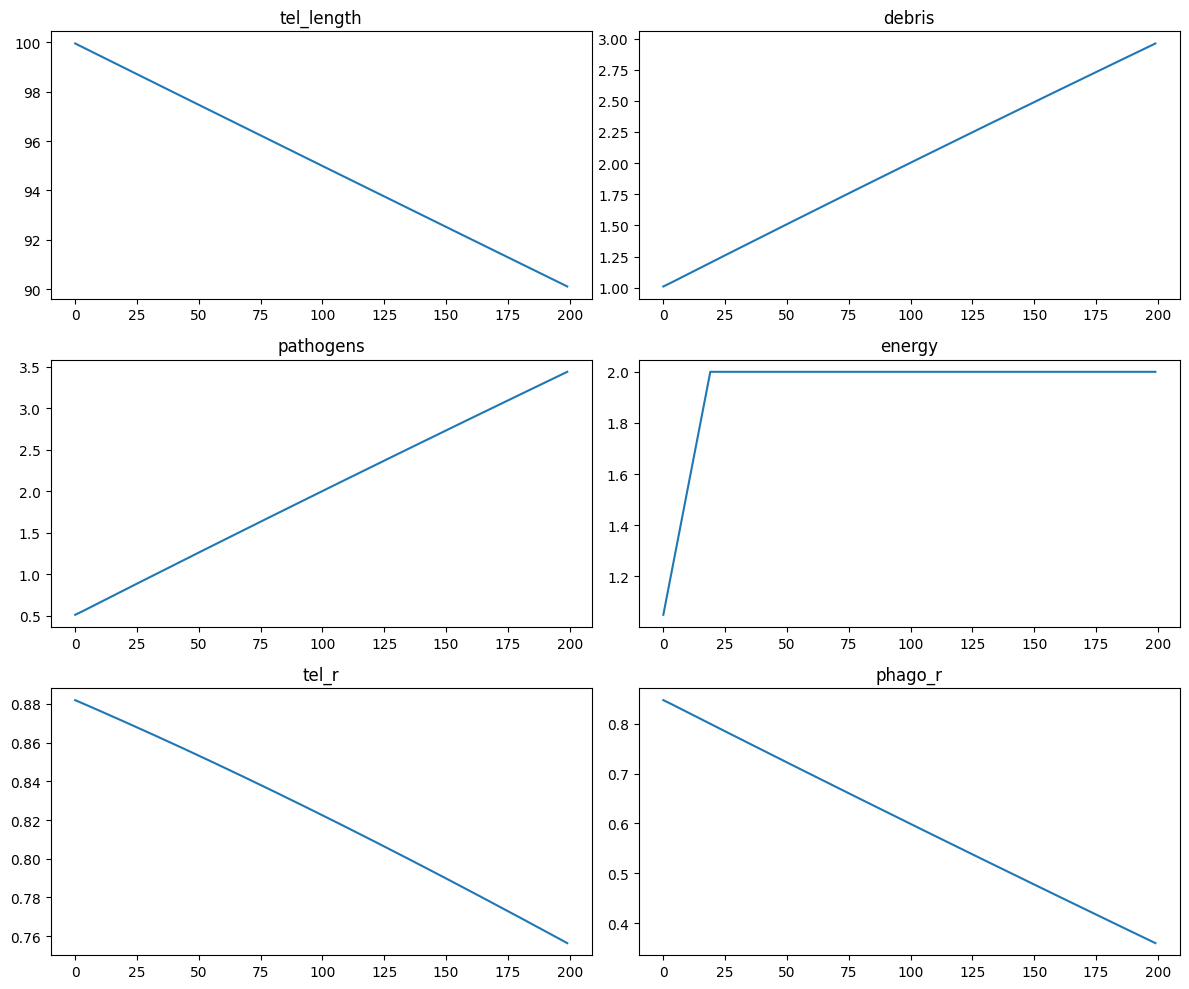


Reward Correlations with total reward:
 reward_total        1.000000
tel_r               0.976688
tel_length          0.972734
phago_r             0.971947
energy             -0.236799
energy_r           -0.236799
pathogens          -0.971947
debris             -0.971947
division_penalty         NaN
Name: reward_total, dtype: float64


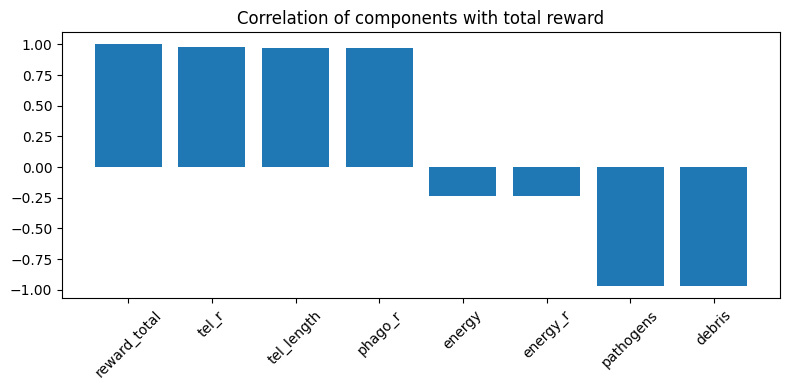

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
from dataclasses import dataclass

# ------------------------- Reward Configuration -------------------------
@dataclass
class RewardConfig:
    tel_target: float = 120.0
    tel_window: float = 40.0
    tel_weight: float = 1.0
    phago_weight: float = 1.0
    energy_weight: float = 0.5
    division_penalty: float = 0.5
    survival_bonus: float = 0.0
    debris_scale: float = 10.0

    def telomere_reward(self, length: float) -> float:
        diff = (length - self.tel_target) / self.tel_window
        return math.exp(-0.5 * (diff ** 2))

    def phagocytosis_reward(self, debris: float, pathogens: float) -> float:
        return 1.0 - ((debris + pathogens) / self.debris_scale)

    def energy_reward(self, energy: float) -> float:
        return (energy / 2.0)

# ------------------------- Model Components -------------------------
class TelomereModule:
    def __init__(self):
        self.length = 100.0
        self.max_length = 200.0

    def update(self, telomerase_activity):
        self.length += 0.1 * telomerase_activity - 0.05
        self.length = np.clip(self.length, 0, self.max_length)

class PhagocytosisModule:
    def __init__(self):
        self.debris = 1.0
        self.pathogens = 0.5

    def update(self, activity):
        self.debris = max(0.0, self.debris - 0.1 * activity)
        self.pathogens = max(0.0, self.pathogens - 0.15 * activity)

# ------------------------- Deep Learning Controller -------------------------
class DeepController(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=32, output_dim=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hc=None):
        out, hc = self.lstm(x, hc)
        out = self.fc(out[:, -1, :])
        return torch.tanh(out), hc

# ------------------------- Virtual Cell -------------------------
class VirtualCell:
    def __init__(self, seed=None, reward_config=None):
        self.tel = TelomereModule()
        self.phago = PhagocytosisModule()
        self.energy = 1.0
        self.divisions = 0
        self.alive = True
        self.reward_config = reward_config if reward_config is not None else RewardConfig()
        self.trace = []

    def step(self, telomerase_activity, phago_activity, divide):
        self.tel.update(telomerase_activity)
        self.phago.update(phago_activity)
        if divide:
            self.divisions += 1
            self.energy -= 0.2
        else:
            self.energy = min(2.0, self.energy + 0.05)

        tel_r = self.reward_config.telomere_reward(self.tel.length)
        phago_r = max(0.0, self.reward_config.phagocytosis_reward(self.phago.debris, self.phago.pathogens))
        energy_r = self.reward_config.energy_reward(self.energy)
        division_penalty = -self.reward_config.division_penalty if divide else 0.0

        reward = (
            self.reward_config.tel_weight * tel_r
            + self.reward_config.phago_weight * phago_r
            + self.reward_config.energy_weight * energy_r
            + division_penalty
            + self.reward_config.survival_bonus
        )

        if self.tel.length > self.tel.max_length * 0.95:
            reward -= 0.2

        self.trace.append({
            'tel_length': self.tel.length,
            'debris': self.phago.debris,
            'pathogens': self.phago.pathogens,
            'energy': self.energy,
            'tel_r': tel_r,
            'phago_r': phago_r,
            'energy_r': energy_r,
            'division_penalty': division_penalty,
            'reward_total': reward
        })
        return reward

# ------------------------- Simulation Loop -------------------------
def run_simulation(steps=100):
    cell = VirtualCell()
    controller = DeepController()
    hc = None
    for t in range(steps):
        state = torch.tensor([[cell.tel.length / 200.0, cell.phago.debris / 10.0, cell.phago.pathogens / 10.0, cell.energy / 2.0]], dtype=torch.float32).unsqueeze(0)
        action, hc = controller(state, hc)
        tel_act, phago_act, divide_act = action[0]
        divide = divide_act.item() > 0.5
        cell.step(float(tel_act.item()), float(phago_act.item()), divide)
    return cell

# ------------------------- Diagnostics -------------------------
def plot_diagnostics(cell):
    data = {k: [step[k] for step in cell.trace] for k in cell.trace[0].keys()}
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    keys = list(data.keys())
    for i, ax in enumerate(axes.flatten()):
        if i < len(keys):
            ax.plot(data[keys[i]])
            ax.set_title(keys[i])
    plt.tight_layout()
    plt.show()

def correlation_analysis(cell):
    import pandas as pd
    data = pd.DataFrame(cell.trace)
    corr = data.corr(numeric_only=True)
    reward_corr = corr['reward_total'].sort_values(ascending=False)
    print("\nReward Correlations with total reward:\n", reward_corr)

    plt.figure(figsize=(8, 4))
    plt.bar(reward_corr.index, reward_corr.values)
    plt.xticks(rotation=45)
    plt.title('Correlation of components with total reward')
    plt.tight_layout()
    plt.show()

# ------------------------- Run Example -------------------------
if __name__ == '__main__':
    cell = run_simulation(200)
    plot_diagnostics(cell)
    correlation_analysis(cell)

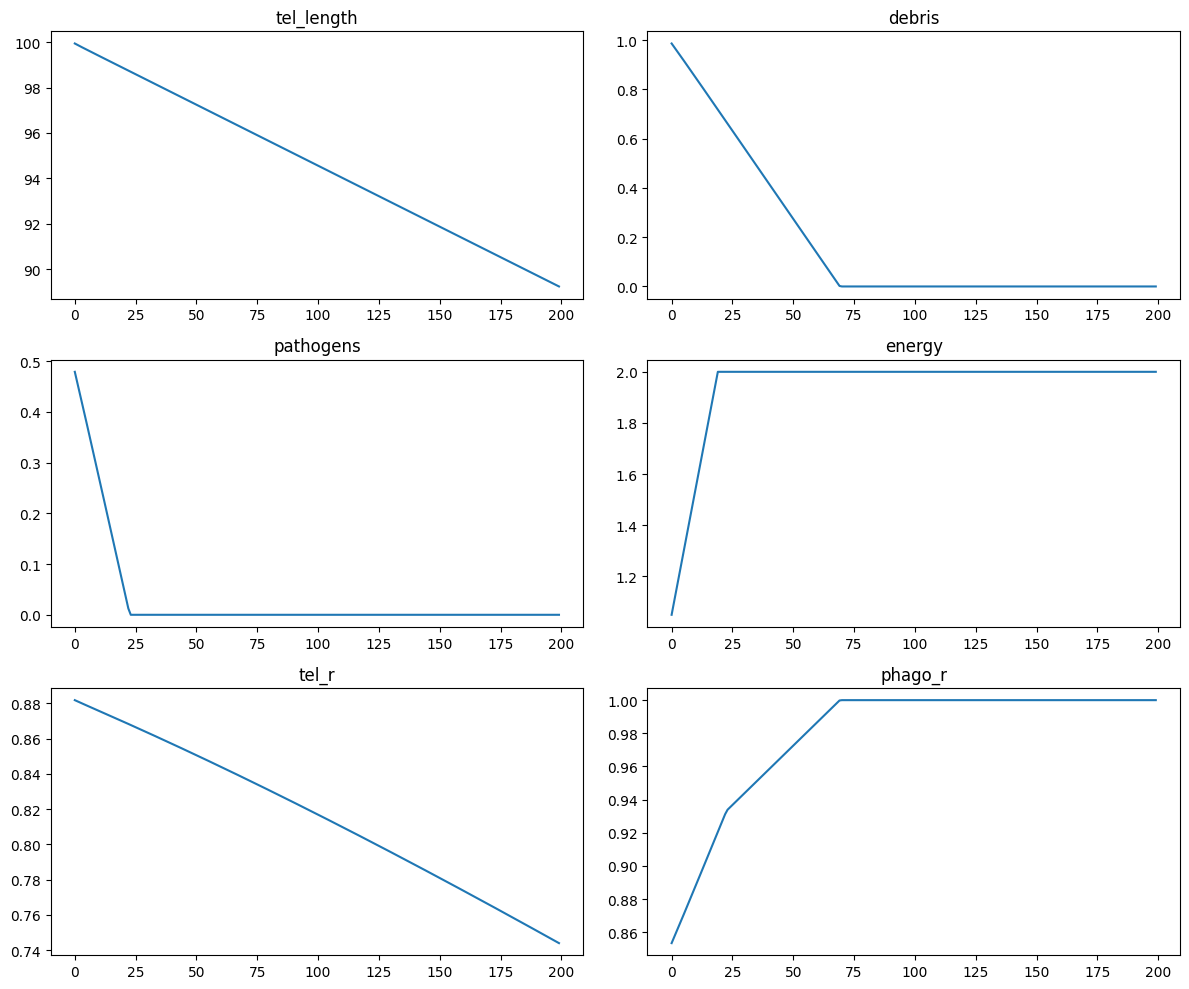


Reward Correlations with total reward:
 reward_total        1.000000
energy              0.905535
energy_r            0.905535
phago_r             0.688627
tel_r              -0.087128
tel_length         -0.112406
debris             -0.579981
pathogens          -0.899524
division_penalty         NaN
Name: reward_total, dtype: float64


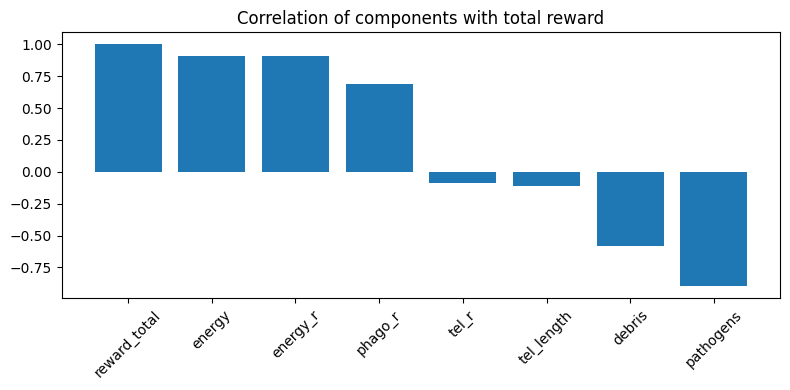


[Auto-tune Longevity] Updated Reward Weights:
Telomere weight: 0.078, Phagocytosis weight: 0.491, Energy weight: 0.431, Division penalty: 0.500


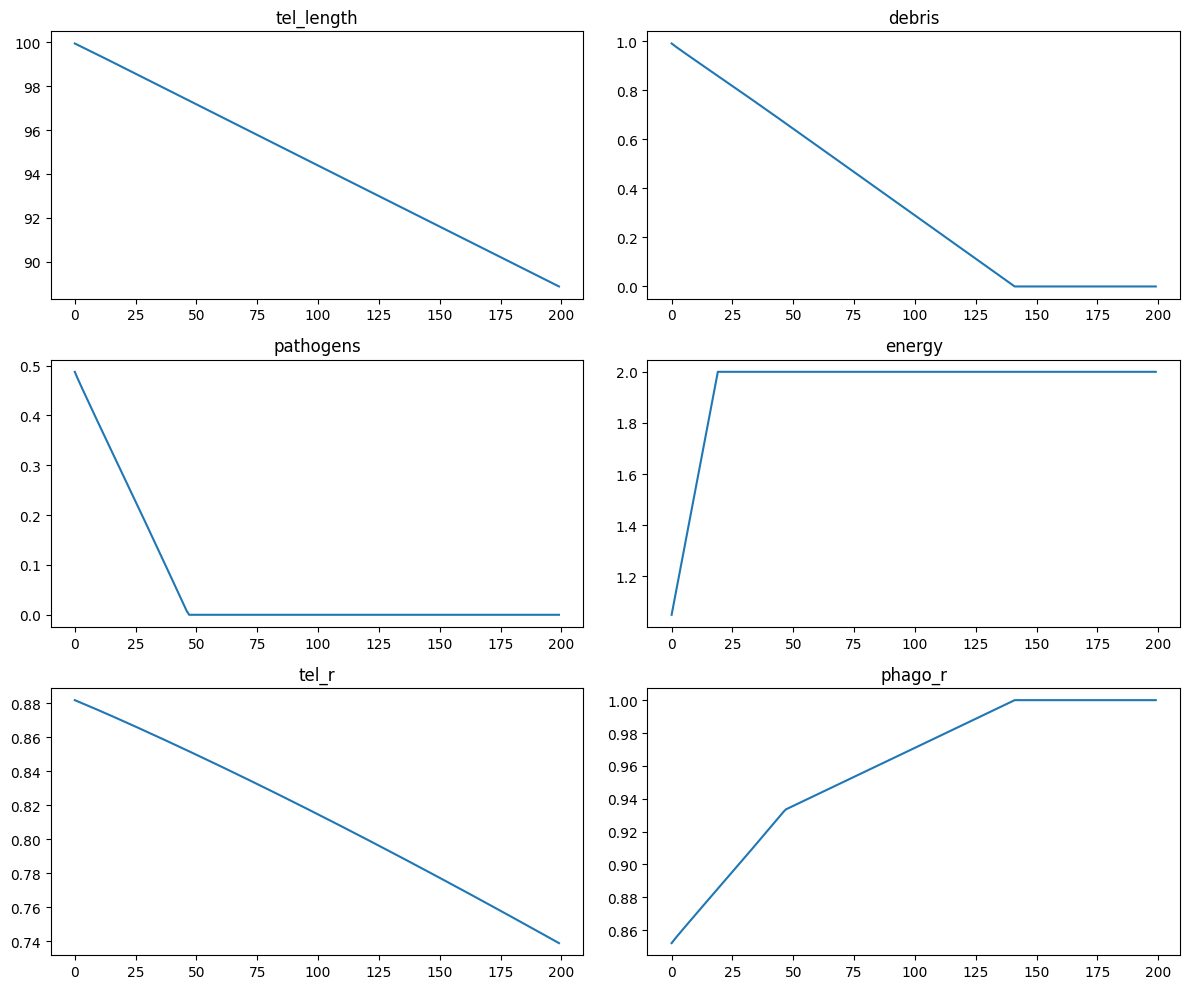


Reward Correlations with total reward:
 reward_total        1.000000
energy              0.960708
energy_r            0.960708
phago_r             0.815100
tel_r              -0.645468
tel_length         -0.663642
debris             -0.718482
pathogens          -0.916048
division_penalty         NaN
Name: reward_total, dtype: float64


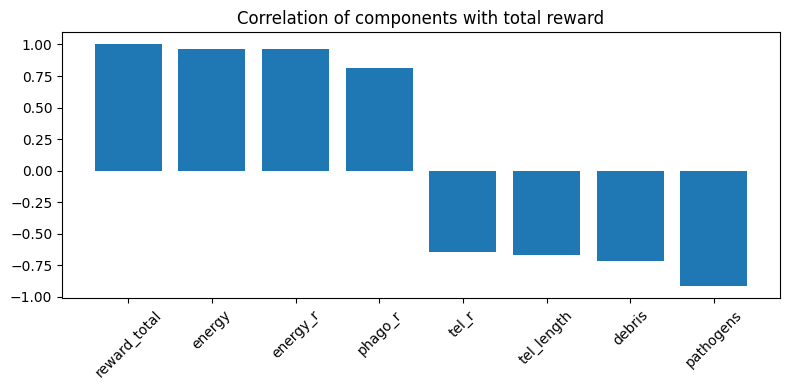

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
from dataclasses import dataclass
import pandas as pd

# ------------------------- Reward Configuration -------------------------
@dataclass
class RewardConfig:
    tel_target: float = 120.0
    tel_window: float = 40.0
    tel_weight: float = 1.0
    phago_weight: float = 1.0
    energy_weight: float = 0.5
    division_penalty: float = 0.5
    survival_bonus: float = 0.0
    debris_scale: float = 10.0

    def telomere_reward(self, length: float) -> float:
        diff = (length - self.tel_target) / self.tel_window
        return math.exp(-0.5 * (diff ** 2))

    def phagocytosis_reward(self, debris: float, pathogens: float) -> float:
        return 1.0 - ((debris + pathogens) / self.debris_scale)

    def energy_reward(self, energy: float) -> float:
        return (energy / 2.0)

# ------------------------- Model Components -------------------------
class TelomereModule:
    def __init__(self):
        self.length = 100.0
        self.max_length = 200.0

    def update(self, telomerase_activity):
        self.length += 0.1 * telomerase_activity - 0.05
        self.length = np.clip(self.length, 0, self.max_length)

class PhagocytosisModule:
    def __init__(self):
        self.debris = 1.0
        self.pathogens = 0.5

    def update(self, activity):
        self.debris = max(0.0, self.debris - 0.1 * activity)
        self.pathogens = max(0.0, self.pathogens - 0.15 * activity)

# ------------------------- Deep Learning Controller -------------------------
class DeepController(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=32, output_dim=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hc=None):
        out, hc = self.lstm(x, hc)
        out = self.fc(out[:, -1, :])
        return torch.tanh(out), hc

# ------------------------- Virtual Cell -------------------------
class VirtualCell:
    def __init__(self, seed=None, reward_config=None):
        self.tel = TelomereModule()
        self.phago = PhagocytosisModule()
        self.energy = 1.0
        self.divisions = 0
        self.alive = True
        self.reward_config = reward_config if reward_config is not None else RewardConfig()
        self.trace = []

    def step(self, telomerase_activity, phago_activity, divide):
        self.tel.update(telomerase_activity)
        self.phago.update(phago_activity)
        if divide:
            self.divisions += 1
            self.energy -= 0.2
        else:
            self.energy = min(2.0, self.energy + 0.05)

        tel_r = self.reward_config.telomere_reward(self.tel.length)
        phago_r = max(0.0, self.reward_config.phagocytosis_reward(self.phago.debris, self.phago.pathogens))
        energy_r = self.reward_config.energy_reward(self.energy)
        division_penalty = -self.reward_config.division_penalty if divide else 0.0

        reward = (
            self.reward_config.tel_weight * tel_r
            + self.reward_config.phago_weight * phago_r
            + self.reward_config.energy_weight * energy_r
            + division_penalty
            + self.reward_config.survival_bonus
        )

        if self.tel.length > self.tel.max_length * 0.95:
            reward -= 0.2

        self.trace.append({
            'tel_length': self.tel.length,
            'debris': self.phago.debris,
            'pathogens': self.phago.pathogens,
            'energy': self.energy,
            'tel_r': tel_r,
            'phago_r': phago_r,
            'energy_r': energy_r,
            'division_penalty': division_penalty,
            'reward_total': reward
        })
        return reward

# ------------------------- Simulation Loop -------------------------
def run_simulation(steps=100, config=None):
    cell = VirtualCell(reward_config=config)
    controller = DeepController()
    hc = None
    for t in range(steps):
        state = torch.tensor([[cell.tel.length / 200.0, cell.phago.debris / 10.0, cell.phago.pathogens / 10.0, cell.energy / 2.0]], dtype=torch.float32).unsqueeze(0)
        action, hc = controller(state, hc)
        tel_act, phago_act, divide_act = action[0]
        divide = divide_act.item() > 0.5
        cell.step(float(tel_act.item()), float(phago_act.item()), divide)
    return cell

# ------------------------- Diagnostics -------------------------
def plot_diagnostics(cell):
    data = {k: [step[k] for step in cell.trace] for k in cell.trace[0].keys()}
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    keys = list(data.keys())
    for i, ax in enumerate(axes.flatten()):
        if i < len(keys):
            ax.plot(data[keys[i]])
            ax.set_title(keys[i])
    plt.tight_layout()
    plt.show()

def correlation_analysis(cell):
    data = pd.DataFrame(cell.trace)
    corr = data.corr(numeric_only=True)
    reward_corr = corr['reward_total'].sort_values(ascending=False)
    print("\nReward Correlations with total reward:\n", reward_corr)

    plt.figure(figsize=(8, 4))
    plt.bar(reward_corr.index, reward_corr.values)
    plt.xticks(rotation=45)
    plt.title('Correlation of components with total reward')
    plt.tight_layout()
    plt.show()

    return reward_corr

# ------------------------- Auto-Tuning for Longevity -------------------------
def auto_tune_rewards(config, reward_corr):
    # Adjust weights based on correlations
    # Positive correlation => increase weight; Negative => decrease
    adjustments = {
        'tel_weight': reward_corr.get('tel_r', 0),
        'phago_weight': reward_corr.get('phago_r', 0),
        'energy_weight': reward_corr.get('energy_r', 0),
    }

    # Apply longevity bias: emphasize telomere + phago, penalize division
    adjustments['tel_weight'] *= 1.5
    adjustments['phago_weight'] *= 1.2
    adjustments['energy_weight'] *= 0.8

    # Normalize weights
    total = sum(abs(v) for v in adjustments.values()) or 1.0
    config.tel_weight = abs(adjustments['tel_weight']) / total
    config.phago_weight = abs(adjustments['phago_weight']) / total
    config.energy_weight = abs(adjustments['energy_weight']) / total

    # Increase division penalty slightly if it's negatively correlated
    if 'division_penalty' in reward_corr and reward_corr['division_penalty'] < 0:
        config.division_penalty = min(1.0, config.division_penalty + 0.1)

    print("\n[Auto-tune Longevity] Updated Reward Weights:")
    print(f"Telomere weight: {config.tel_weight:.3f}, Phagocytosis weight: {config.phago_weight:.3f}, Energy weight: {config.energy_weight:.3f}, Division penalty: {config.division_penalty:.3f}")
    return config

# ------------------------- Run Example -------------------------
if __name__ == '__main__':
    config = RewardConfig()
    cell = run_simulation(200, config)
    plot_diagnostics(cell)
    corr = correlation_analysis(cell)
    config = auto_tune_rewards(config, corr)

    # Optionally rerun simulation with tuned config
    cell_tuned = run_simulation(200, config)
    plot_diagnostics(cell_tuned)
    correlation_analysis(cell_tuned)

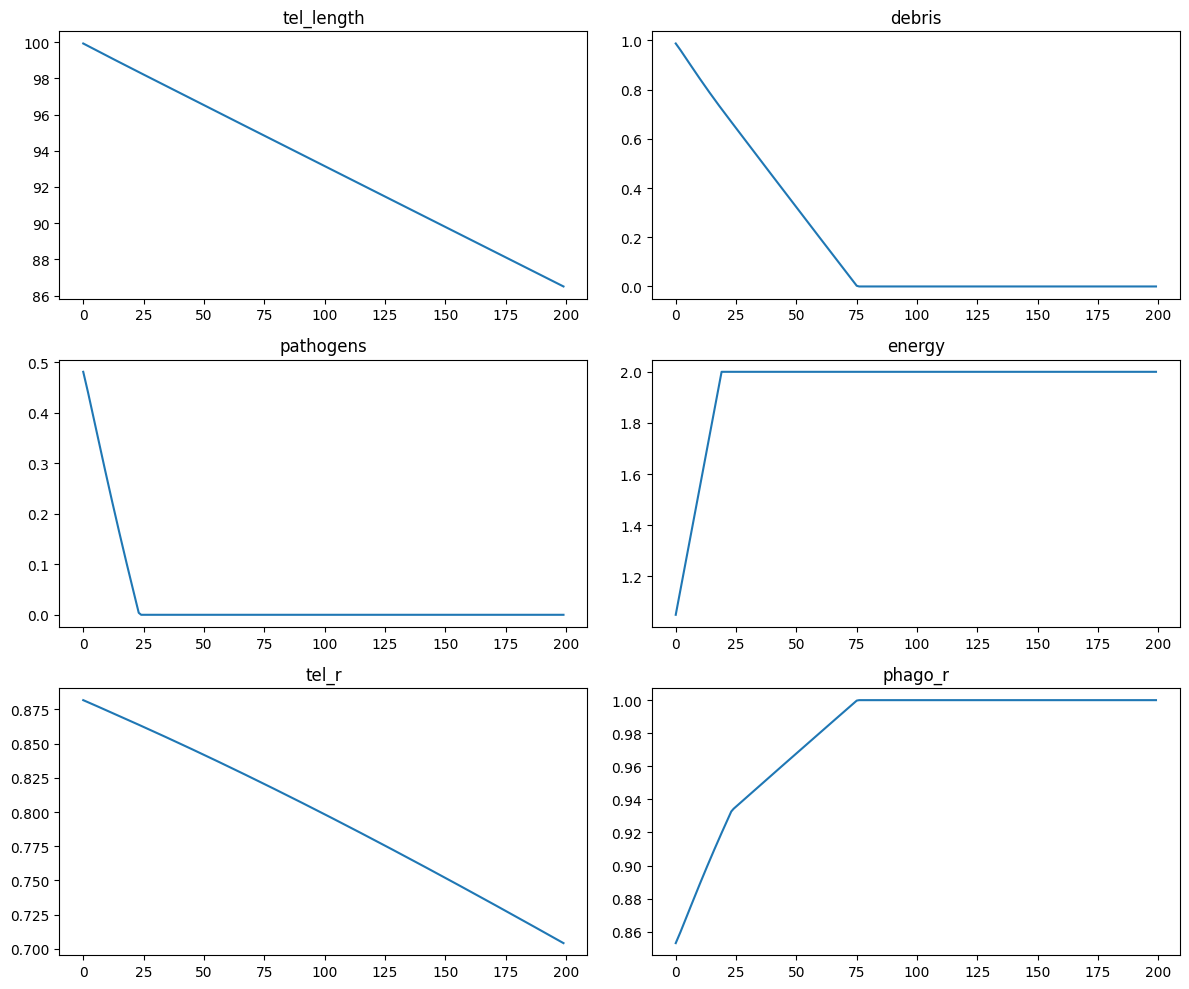


Reward Correlations with total reward:
 reward_total        1.000000
energy              0.827112
energy_r            0.827112
phago_r             0.529790
tel_r               0.093287
tel_length          0.064596
debris             -0.407069
pathogens          -0.812572
division_penalty         NaN
Name: reward_total, dtype: float64


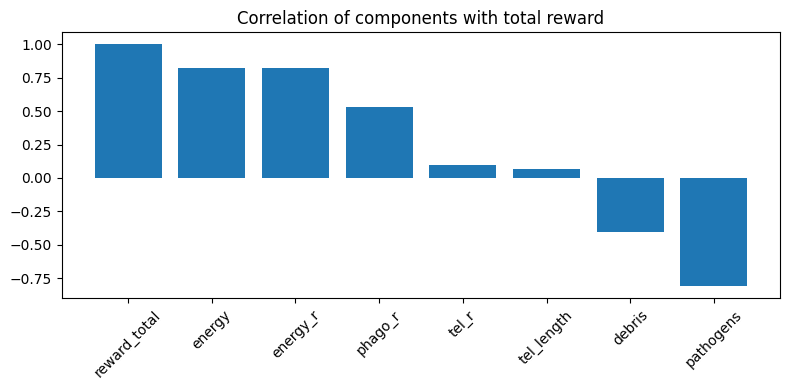


[Auto-tune Longevity] Updated Reward Weights:
Telomere weight: 0.097, Phagocytosis weight: 0.442, Energy weight: 0.460, Division penalty: 0.500


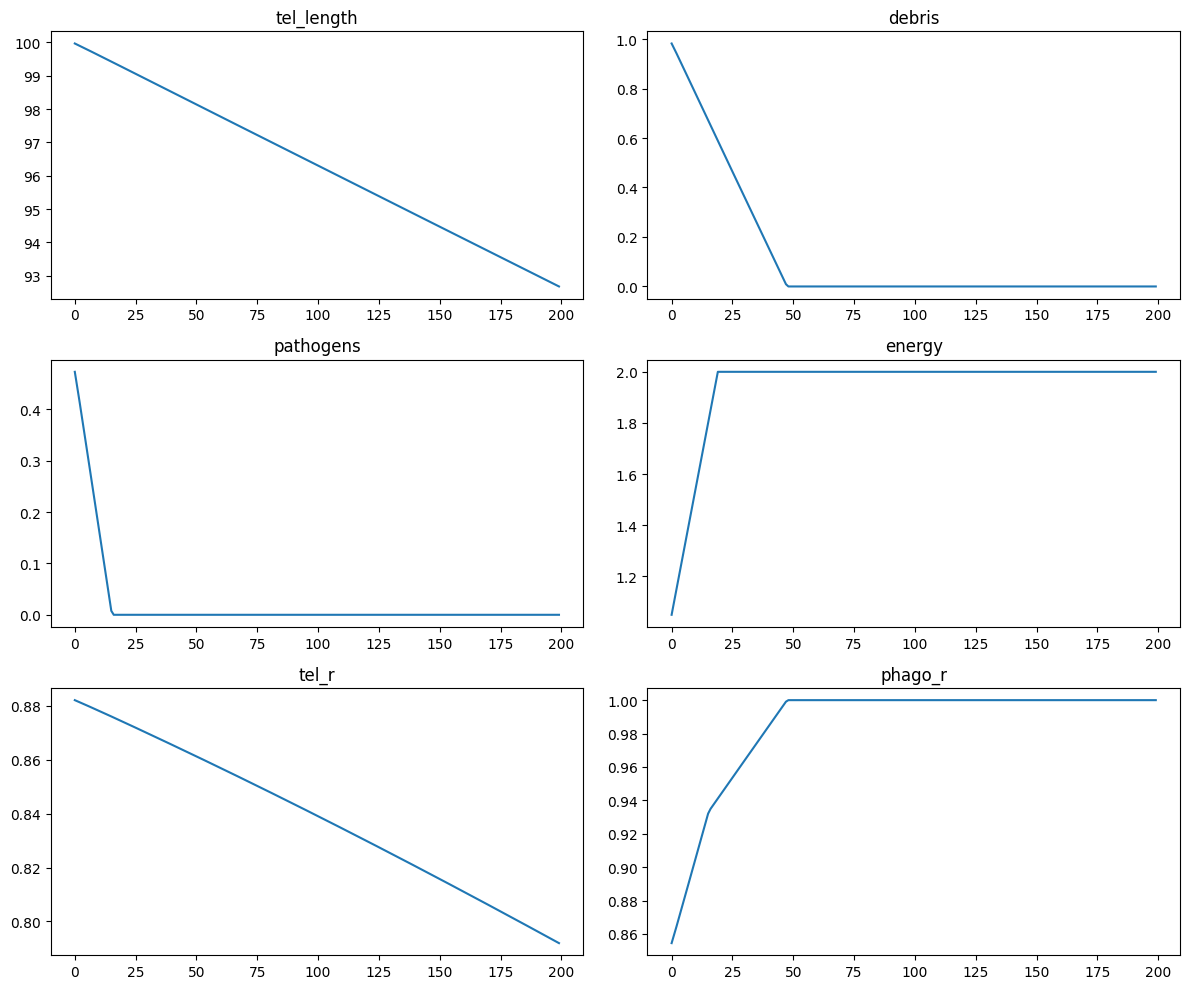


Reward Correlations with total reward:
 reward_total        1.000000
energy              0.994734
energy_r            0.994734
phago_r             0.934033
tel_r              -0.463334
tel_length         -0.478533
debris             -0.867950
pathogens          -0.972313
division_penalty         NaN
Name: reward_total, dtype: float64


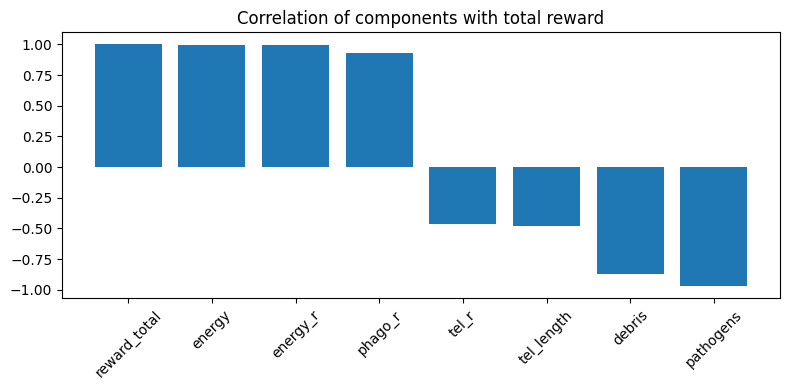

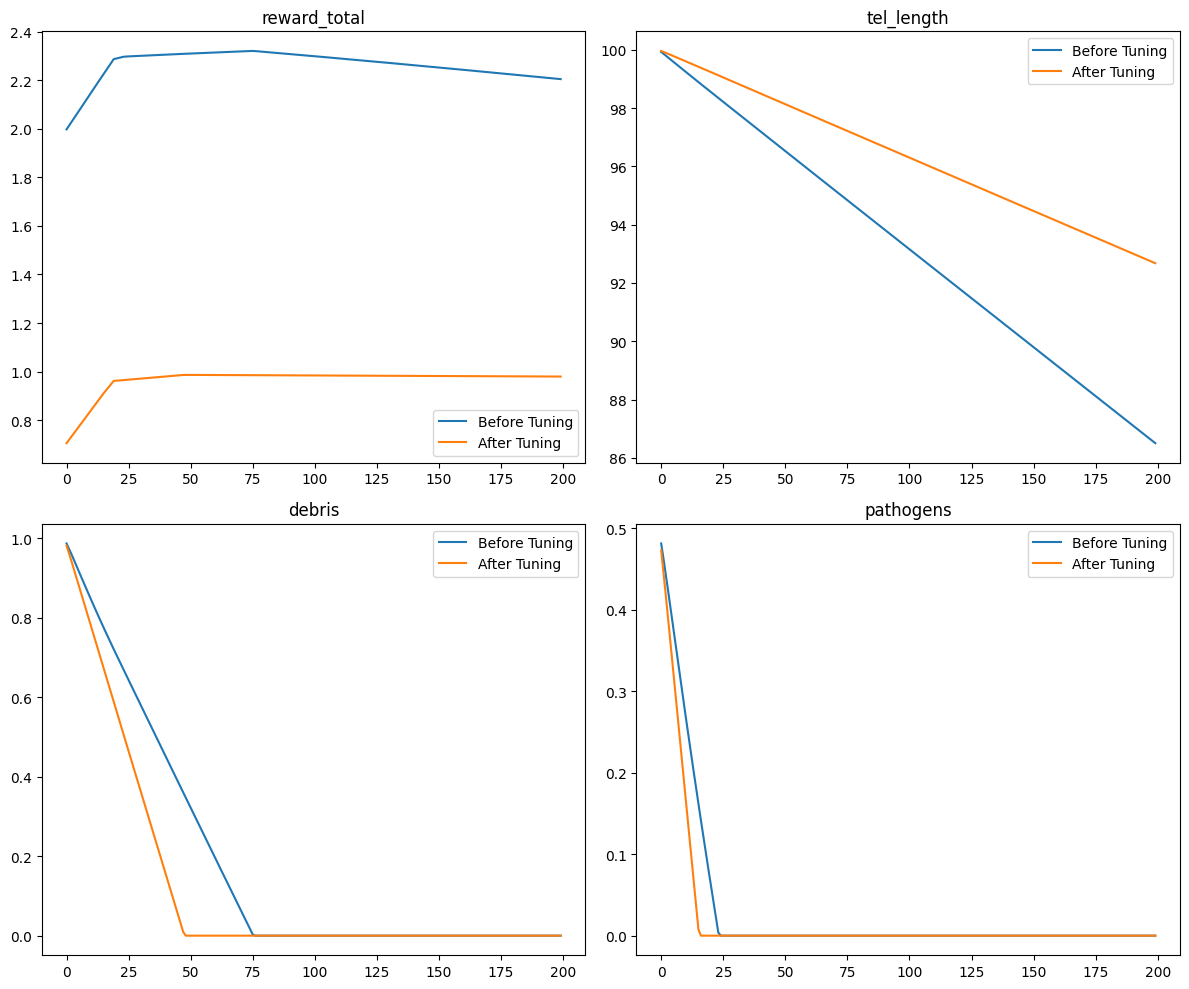


Performance Summary (Before vs After Tuning):
              before_mean  before_std  after_mean  after_std
reward_total     2.263644    0.059272    0.967228   0.050629
tel_length      93.196475    3.889645   96.321700   2.115941
debris           0.184520    0.294185    0.118996   0.254257
pathogens        0.028577    0.092207    0.019343   0.077142


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
from dataclasses import dataclass
import pandas as pd

# ------------------------- Reward Configuration -------------------------
@dataclass
class RewardConfig:
    tel_target: float = 120.0
    tel_window: float = 40.0
    tel_weight: float = 1.0
    phago_weight: float = 1.0
    energy_weight: float = 0.5
    division_penalty: float = 0.5
    survival_bonus: float = 0.0
    debris_scale: float = 10.0

    def telomere_reward(self, length: float) -> float:
        diff = (length - self.tel_target) / self.tel_window
        return math.exp(-0.5 * (diff ** 2))

    def phagocytosis_reward(self, debris: float, pathogens: float) -> float:
        return 1.0 - ((debris + pathogens) / self.debris_scale)

    def energy_reward(self, energy: float) -> float:
        return (energy / 2.0)

# ------------------------- Model Components -------------------------
class TelomereModule:
    def __init__(self):
        self.length = 100.0
        self.max_length = 200.0

    def update(self, telomerase_activity):
        self.length += 0.1 * telomerase_activity - 0.05
        self.length = np.clip(self.length, 0, self.max_length)

class PhagocytosisModule:
    def __init__(self):
        self.debris = 1.0
        self.pathogens = 0.5

    def update(self, activity):
        self.debris = max(0.0, self.debris - 0.1 * activity)
        self.pathogens = max(0.0, self.pathogens - 0.15 * activity)

# ------------------------- Deep Learning Controller -------------------------
class DeepController(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=32, output_dim=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hc=None):
        out, hc = self.lstm(x, hc)
        out = self.fc(out[:, -1, :])
        return torch.tanh(out), hc

# ------------------------- Virtual Cell -------------------------
class VirtualCell:
    def __init__(self, seed=None, reward_config=None):
        self.tel = TelomereModule()
        self.phago = PhagocytosisModule()
        self.energy = 1.0
        self.divisions = 0
        self.alive = True
        self.reward_config = reward_config if reward_config is not None else RewardConfig()
        self.trace = []

    def step(self, telomerase_activity, phago_activity, divide):
        self.tel.update(telomerase_activity)
        self.phago.update(phago_activity)
        if divide:
            self.divisions += 1
            self.energy -= 0.2
        else:
            self.energy = min(2.0, self.energy + 0.05)

        tel_r = self.reward_config.telomere_reward(self.tel.length)
        phago_r = max(0.0, self.reward_config.phagocytosis_reward(self.phago.debris, self.phago.pathogens))
        energy_r = self.reward_config.energy_reward(self.energy)
        division_penalty = -self.reward_config.division_penalty if divide else 0.0

        reward = (
            self.reward_config.tel_weight * tel_r
            + self.reward_config.phago_weight * phago_r
            + self.reward_config.energy_weight * energy_r
            + division_penalty
            + self.reward_config.survival_bonus
        )

        if self.tel.length > self.tel.max_length * 0.95:
            reward -= 0.2

        self.trace.append({
            'tel_length': self.tel.length,
            'debris': self.phago.debris,
            'pathogens': self.phago.pathogens,
            'energy': self.energy,
            'tel_r': tel_r,
            'phago_r': phago_r,
            'energy_r': energy_r,
            'division_penalty': division_penalty,
            'reward_total': reward
        })
        return reward

# ------------------------- Simulation Loop -------------------------
def run_simulation(steps=100, config=None):
    cell = VirtualCell(reward_config=config)
    controller = DeepController()
    hc = None
    for t in range(steps):
        state = torch.tensor([[cell.tel.length / 200.0, cell.phago.debris / 10.0, cell.phago.pathogens / 10.0, cell.energy / 2.0]], dtype=torch.float32).unsqueeze(0)
        action, hc = controller(state, hc)
        tel_act, phago_act, divide_act = action[0]
        divide = divide_act.item() > 0.5
        cell.step(float(tel_act.item()), float(phago_act.item()), divide)
    return cell

# ------------------------- Diagnostics -------------------------
def plot_diagnostics(cell):
    data = {k: [step[k] for step in cell.trace] for k in cell.trace[0].keys()}
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    keys = list(data.keys())
    for i, ax in enumerate(axes.flatten()):
        if i < len(keys):
            ax.plot(data[keys[i]])
            ax.set_title(keys[i])
    plt.tight_layout()
    plt.show()

def correlation_analysis(cell):
    data = pd.DataFrame(cell.trace)
    corr = data.corr(numeric_only=True)
    reward_corr = corr['reward_total'].sort_values(ascending=False)
    print("\nReward Correlations with total reward:\n", reward_corr)

    plt.figure(figsize=(8, 4))
    plt.bar(reward_corr.index, reward_corr.values)
    plt.xticks(rotation=45)
    plt.title('Correlation of components with total reward')
    plt.tight_layout()
    plt.show()

    return reward_corr

# ------------------------- Auto-Tuning for Longevity -------------------------
def auto_tune_rewards(config, reward_corr):
    adjustments = {
        'tel_weight': reward_corr.get('tel_r', 0),
        'phago_weight': reward_corr.get('phago_r', 0),
        'energy_weight': reward_corr.get('energy_r', 0),
    }
    adjustments['tel_weight'] *= 1.5
    adjustments['phago_weight'] *= 1.2
    adjustments['energy_weight'] *= 0.8
    total = sum(abs(v) for v in adjustments.values()) or 1.0
    config.tel_weight = abs(adjustments['tel_weight']) / total
    config.phago_weight = abs(adjustments['phago_weight']) / total
    config.energy_weight = abs(adjustments['energy_weight']) / total
    if 'division_penalty' in reward_corr and reward_corr['division_penalty'] < 0:
        config.division_penalty = min(1.0, config.division_penalty + 0.1)
    print("\n[Auto-tune Longevity] Updated Reward Weights:")
    print(f"Telomere weight: {config.tel_weight:.3f}, Phagocytosis weight: {config.phago_weight:.3f}, Energy weight: {config.energy_weight:.3f}, Division penalty: {config.division_penalty:.3f}")
    return config

# ------------------------- Performance Comparison -------------------------
def performance_comparison(cell_before, cell_after):
    metrics = ['reward_total', 'tel_length', 'debris', 'pathogens']
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    for i, metric in enumerate(metrics):
        axes[i].plot([step[metric] for step in cell_before.trace], label='Before Tuning')
        axes[i].plot([step[metric] for step in cell_after.trace], label='After Tuning')
        axes[i].set_title(metric)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    # Summary statistics
    summary = {}
    for metric in metrics:
        before_vals = np.array([step[metric] for step in cell_before.trace])
        after_vals = np.array([step[metric] for step in cell_after.trace])
        summary[metric] = {
            'before_mean': before_vals.mean(), 'before_std': before_vals.std(),
            'after_mean': after_vals.mean(), 'after_std': after_vals.std()
        }
    summary_df = pd.DataFrame(summary).T
    print("\nPerformance Summary (Before vs After Tuning):")
    print(summary_df)
    summary_df.to_csv('performance_summary.csv')

# ------------------------- Run Example -------------------------
if __name__ == '__main__':
    config = RewardConfig()
    cell_before = run_simulation(200, config)
    plot_diagnostics(cell_before)
    corr = correlation_analysis(cell_before)
    config = auto_tune_rewards(config, corr)
    cell_after = run_simulation(200, config)
    plot_diagnostics(cell_after)
    correlation_analysis(cell_after)
    performance_comparison(cell_before, cell_after)

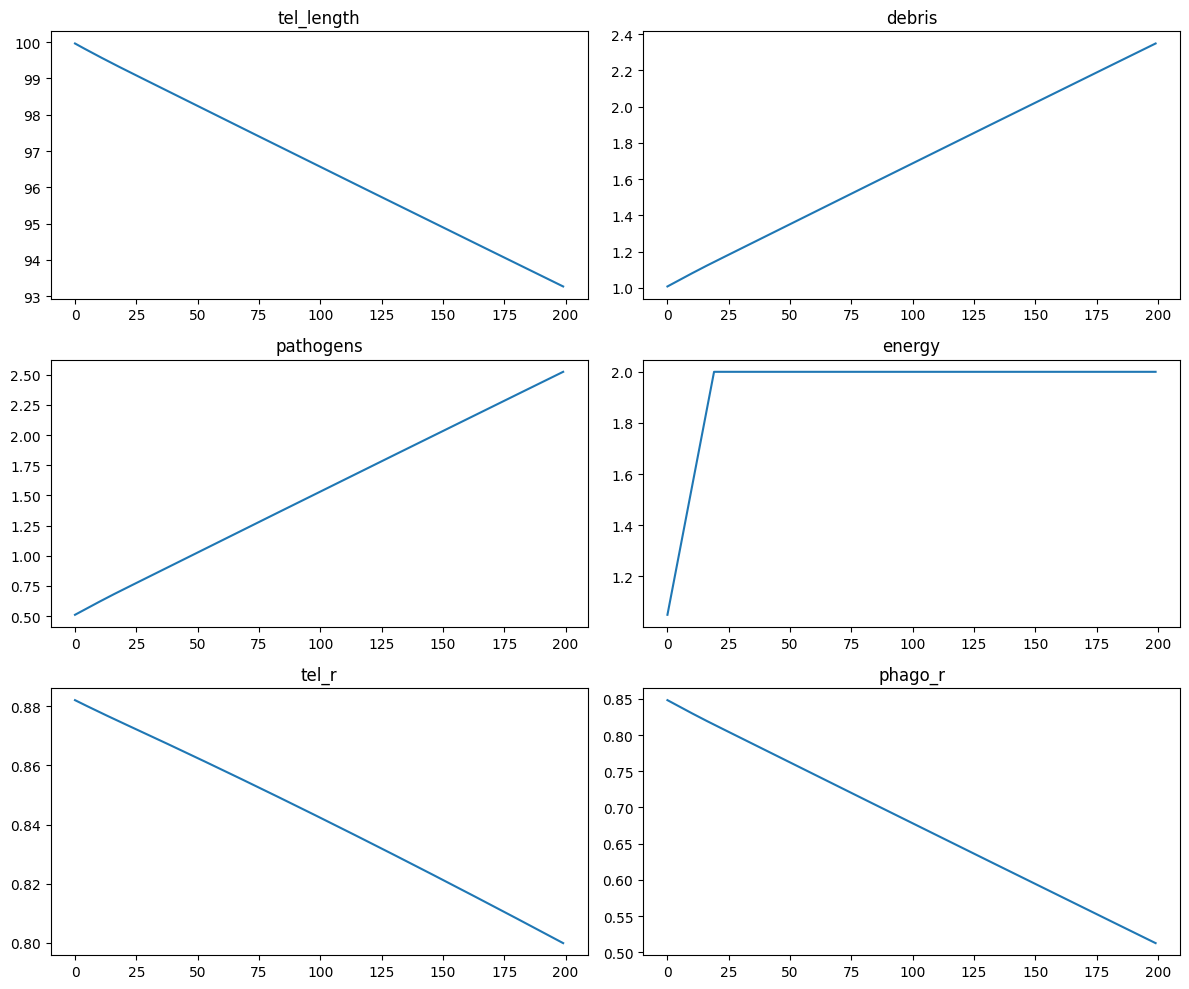


Reward Correlations with total reward:
 reward_total        1.000000
tel_r               0.941305
phago_r             0.936475
tel_length          0.936353
energy             -0.117010
energy_r           -0.117010
debris             -0.936475
pathogens          -0.936475
division_penalty         NaN
Name: reward_total, dtype: float64


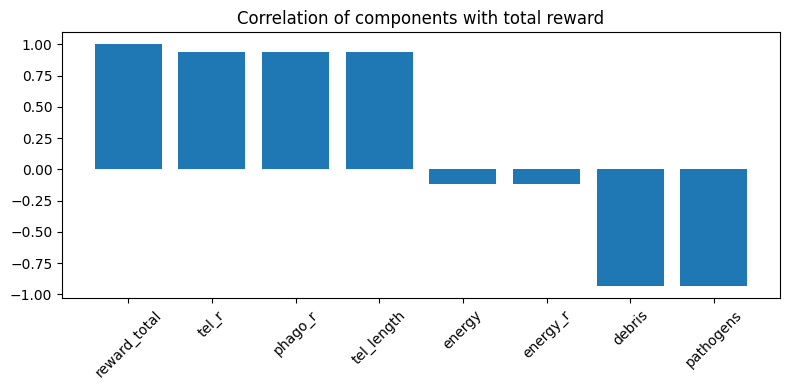


[Auto-tune Longevity] Updated Reward Weights:
Telomere weight: 0.537, Phagocytosis weight: 0.427, Energy weight: 0.036, Division penalty: 0.500


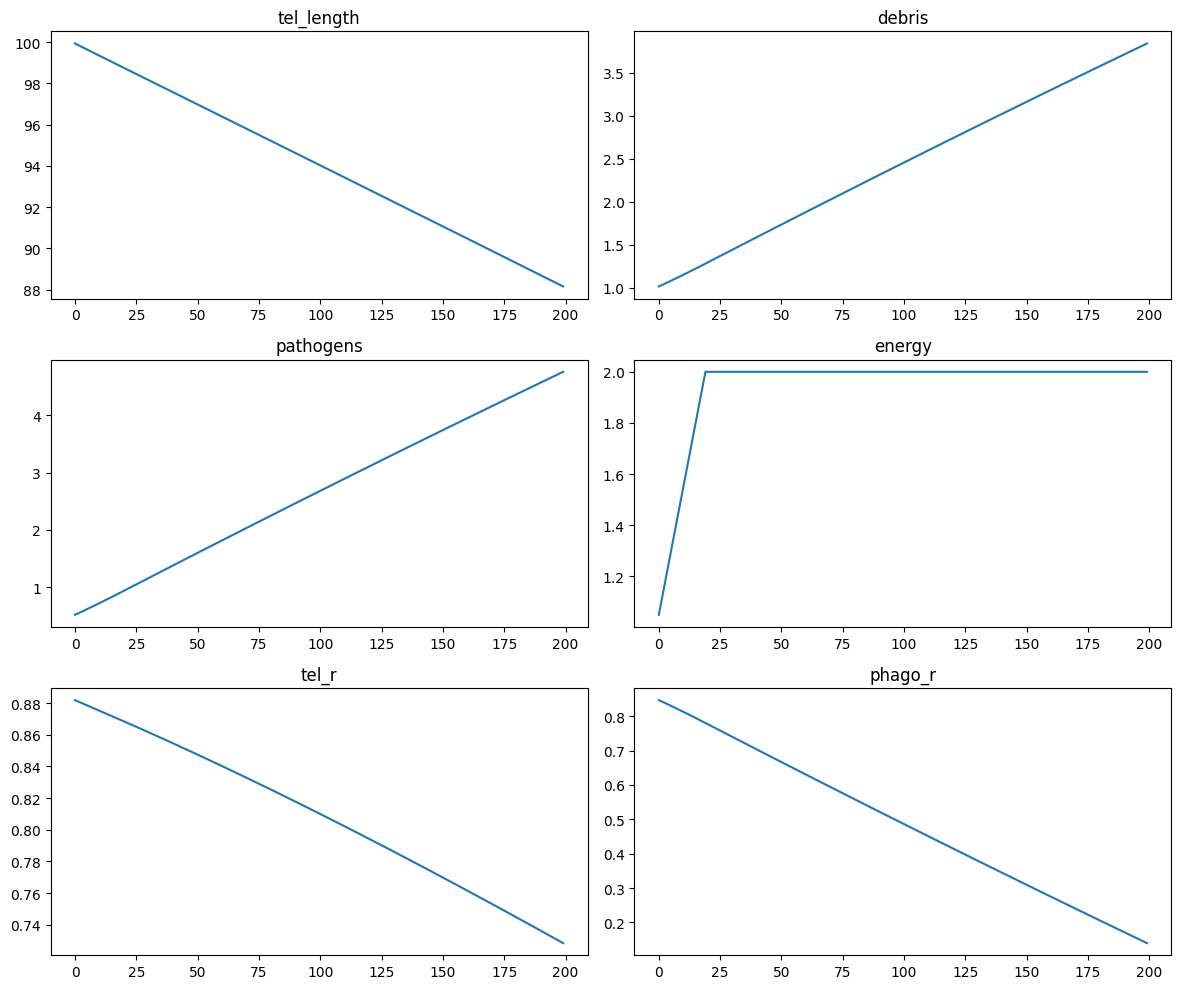


Reward Correlations with total reward:
 reward_total        1.000000
tel_length          0.999675
tel_r               0.999558
phago_r             0.999529
energy             -0.431615
energy_r           -0.431615
pathogens          -0.999529
debris             -0.999529
division_penalty         NaN
Name: reward_total, dtype: float64


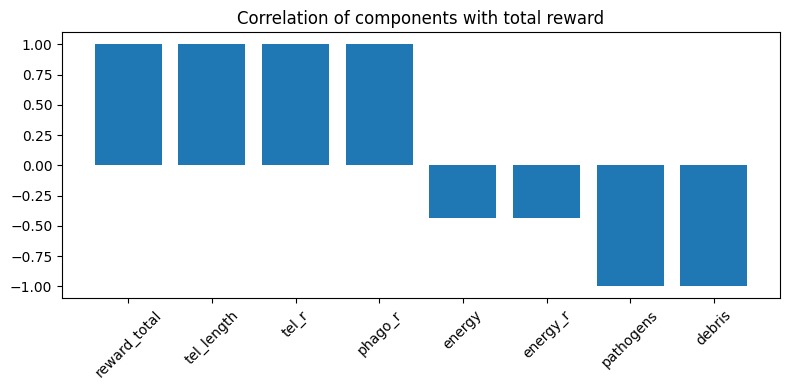

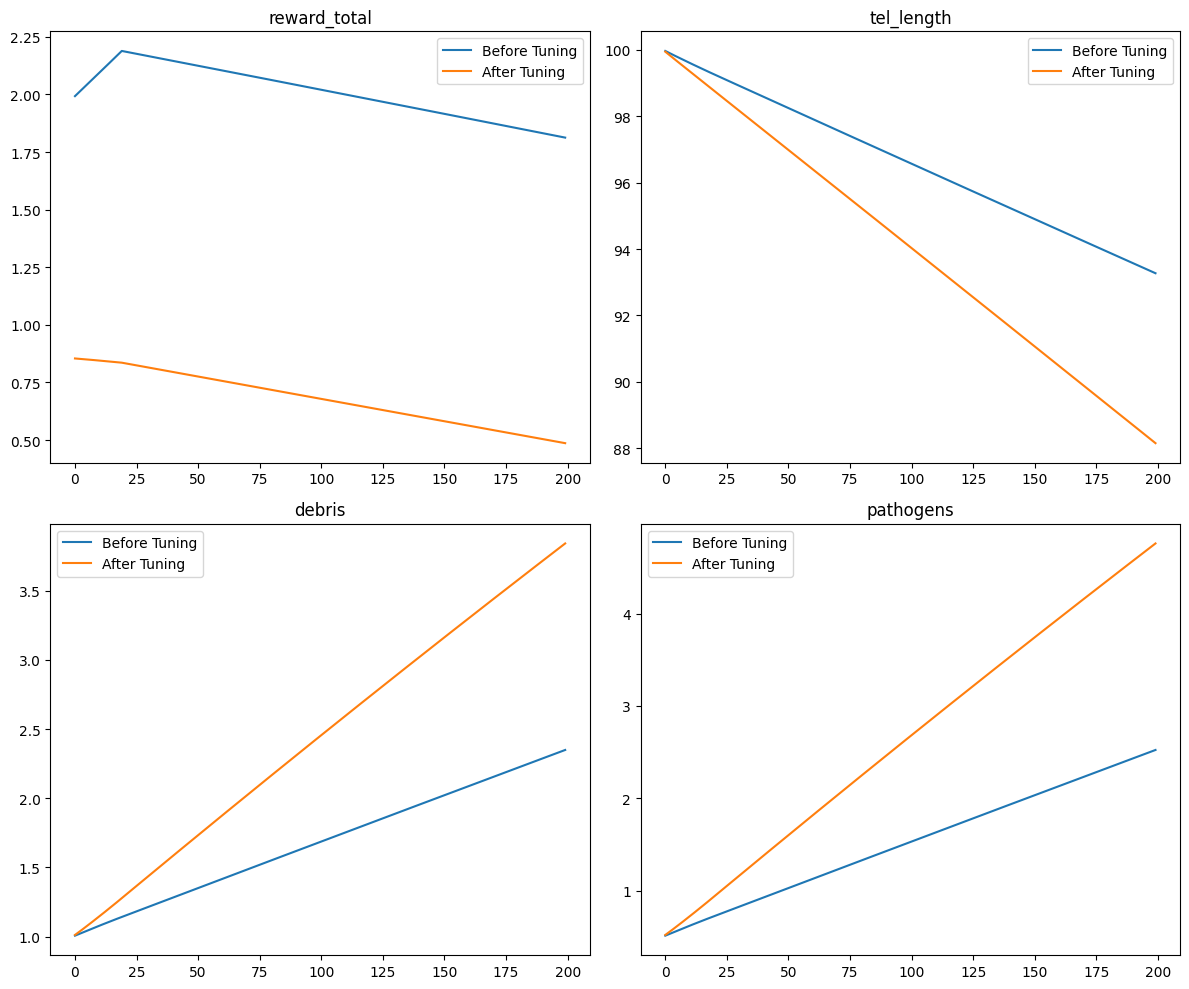


Performance Summary (Before vs After Tuning):
              before_mean  before_std  after_mean  after_std
reward_total     2.009288    0.108178    0.678469   0.110710
tel_length      96.588885    1.932359   94.052893   3.415740
debris           1.683122    0.387594    2.439142   0.824327
pathogens        1.524683    0.581390    2.658714   1.236491


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
from dataclasses import dataclass
import pandas as pd

# ------------------------- Reward Configuration -------------------------
@dataclass
class RewardConfig:
    tel_target: float = 120.0
    tel_window: float = 40.0
    tel_weight: float = 1.0
    phago_weight: float = 1.0
    energy_weight: float = 0.5
    division_penalty: float = 0.5
    survival_bonus: float = 0.0
    debris_scale: float = 10.0

    def telomere_reward(self, length: float) -> float:
        diff = (length - self.tel_target) / self.tel_window
        return math.exp(-0.5 * (diff ** 2))

    def phagocytosis_reward(self, debris: float, pathogens: float) -> float:
        return 1.0 - ((debris + pathogens) / self.debris_scale)

    def energy_reward(self, energy: float) -> float:
        return (energy / 2.0)

# ------------------------- Model Components -------------------------
class TelomereModule:
    def __init__(self):
        self.length = 100.0
        self.max_length = 200.0

    def update(self, telomerase_activity):
        self.length += 0.1 * telomerase_activity - 0.05
        self.length = np.clip(self.length, 0, self.max_length)

class PhagocytosisModule:
    def __init__(self):
        self.debris = 1.0
        self.pathogens = 0.5

    def update(self, activity):
        self.debris = max(0.0, self.debris - 0.1 * activity)
        self.pathogens = max(0.0, self.pathogens - 0.15 * activity)

# ------------------------- Deep Learning Controller -------------------------
class DeepController(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=32, output_dim=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hc=None):
        out, hc = self.lstm(x, hc)
        out = self.fc(out[:, -1, :])
        return torch.tanh(out), hc

# ------------------------- Virtual Cell -------------------------
class VirtualCell:
    def __init__(self, seed=None, reward_config=None):
        self.tel = TelomereModule()
        self.phago = PhagocytosisModule()
        self.energy = 1.0
        self.divisions = 0
        self.alive = True
        self.reward_config = reward_config if reward_config is not None else RewardConfig()
        self.trace = []

    def step(self, telomerase_activity, phago_activity, divide):
        self.tel.update(telomerase_activity)
        self.phago.update(phago_activity)
        if divide:
            self.divisions += 1
            self.energy -= 0.2
        else:
            self.energy = min(2.0, self.energy + 0.05)

        tel_r = self.reward_config.telomere_reward(self.tel.length)
        phago_r = max(0.0, self.reward_config.phagocytosis_reward(self.phago.debris, self.phago.pathogens))
        energy_r = self.reward_config.energy_reward(self.energy)
        division_penalty = -self.reward_config.division_penalty if divide else 0.0

        reward = (
            self.reward_config.tel_weight * tel_r
            + self.reward_config.phago_weight * phago_r
            + self.reward_config.energy_weight * energy_r
            + division_penalty
            + self.reward_config.survival_bonus
        )

        if self.tel.length > self.tel.max_length * 0.95:
            reward -= 0.2

        self.trace.append({
            'tel_length': self.tel.length,
            'debris': self.phago.debris,
            'pathogens': self.phago.pathogens,
            'energy': self.energy,
            'tel_r': tel_r,
            'phago_r': phago_r,
            'energy_r': energy_r,
            'division_penalty': division_penalty,
            'reward_total': reward
        })
        return reward

# ------------------------- Simulation Loop -------------------------
def run_simulation(steps=100, config=None):
    cell = VirtualCell(reward_config=config)
    controller = DeepController()
    hc = None
    for t in range(steps):
        state = torch.tensor([[cell.tel.length / 200.0, cell.phago.debris / 10.0, cell.phago.pathogens / 10.0, cell.energy / 2.0]], dtype=torch.float32).unsqueeze(0)
        action, hc = controller(state, hc)
        tel_act, phago_act, divide_act = action[0]
        divide = divide_act.item() > 0.5
        cell.step(float(tel_act.item()), float(phago_act.item()), divide)
    return cell

# ------------------------- Diagnostics -------------------------
def plot_diagnostics(cell):
    data = {k: [step[k] for step in cell.trace] for k in cell.trace[0].keys()}
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    keys = list(data.keys())
    for i, ax in enumerate(axes.flatten()):
        if i < len(keys):
            ax.plot(data[keys[i]])
            ax.set_title(keys[i])
    plt.tight_layout()
    plt.show()

def correlation_analysis(cell):
    data = pd.DataFrame(cell.trace)
    corr = data.corr(numeric_only=True)
    reward_corr = corr['reward_total'].sort_values(ascending=False)
    print("\nReward Correlations with total reward:\n", reward_corr)

    plt.figure(figsize=(8, 4))
    plt.bar(reward_corr.index, reward_corr.values)
    plt.xticks(rotation=45)
    plt.title('Correlation of components with total reward')
    plt.tight_layout()
    plt.show()

    return reward_corr

# ------------------------- Auto-Tuning for Longevity -------------------------
def auto_tune_rewards(config, reward_corr):
    adjustments = {
        'tel_weight': reward_corr.get('tel_r', 0),
        'phago_weight': reward_corr.get('phago_r', 0),
        'energy_weight': reward_corr.get('energy_r', 0),
    }
    adjustments['tel_weight'] *= 1.5
    adjustments['phago_weight'] *= 1.2
    adjustments['energy_weight'] *= 0.8
    total = sum(abs(v) for v in adjustments.values()) or 1.0
    config.tel_weight = abs(adjustments['tel_weight']) / total
    config.phago_weight = abs(adjustments['phago_weight']) / total
    config.energy_weight = abs(adjustments['energy_weight']) / total
    if 'division_penalty' in reward_corr and reward_corr['division_penalty'] < 0:
        config.division_penalty = min(1.0, config.division_penalty + 0.1)
    print("\n[Auto-tune Longevity] Updated Reward Weights:")
    print(f"Telomere weight: {config.tel_weight:.3f}, Phagocytosis weight: {config.phago_weight:.3f}, Energy weight: {config.energy_weight:.3f}, Division penalty: {config.division_penalty:.3f}")
    return config

# ------------------------- Performance Comparison -------------------------
def performance_comparison(cell_before, cell_after):
    metrics = ['reward_total', 'tel_length', 'debris', 'pathogens']
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    for i, metric in enumerate(metrics):
        axes[i].plot([step[metric] for step in cell_before.trace], label='Before Tuning')
        axes[i].plot([step[metric] for step in cell_after.trace], label='After Tuning')
        axes[i].set_title(metric)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    # Summary statistics
    summary = {}
    for metric in metrics:
        before_vals = np.array([step[metric] for step in cell_before.trace])
        after_vals = np.array([step[metric] for step in cell_after.trace])
        summary[metric] = {
            'before_mean': before_vals.mean(), 'before_std': before_vals.std(),
            'after_mean': after_vals.mean(), 'after_std': after_vals.std()
        }
    summary_df = pd.DataFrame(summary).T
    print("\nPerformance Summary (Before vs After Tuning):")
    print(summary_df)
    summary_df.to_csv('performance_summary.csv')

# ------------------------- Run Example -------------------------
if __name__ == '__main__':
    config = RewardConfig()
    cell_before = run_simulation(200, config)
    plot_diagnostics(cell_before)
    corr = correlation_analysis(cell_before)
    config = auto_tune_rewards(config, corr)
    cell_after = run_simulation(200, config)
    plot_diagnostics(cell_after)
    correlation_analysis(cell_after)
    performance_comparison(cell_before, cell_after)